In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from functools import reduce
import scipy
from copy import deepcopy
from scipy.linalg import logm
import numpy as np
import dill


In [3]:
%%bash
ls 

2q_controls
controls_8
controls_9
convex.py
example_worked
GRAPE.py
GRAPE.pyc
handcrafted.pkl
__init__.py
just_pickled_controls7.pkl
just_pickled_controls9.pkl
pauli_channel_approximation.py
pickled_controls0.pkl
pickled_controls10.pkl
pickled_controls1.pkl
pickled_controls2.pkl
pickled_controls3.pkl
pickled_controls4.pkl
pickled_controls5.pkl
pickled_controls6.pkl
pickled_controls7.pkl
pickled_controls8.pkl
__pycache__
Quadratic Programs Working (sqrtX).ipynb
Quadratic Programs Working (sqrtY).ipynb
Quadratic Programs Working (sqrtZZ).ipynb
README.md
requirements.txt


In [5]:
import os
from os.path import isfile, join
mypath = 'controls_9'
onlyfiles = [f for f in os.listdir(mypath) if isfile(join(mypath, f))]

In [6]:
controls = [dill.load(open(file, 'rb')) for file in [os.path.join(mypath, file) for file in onlyfiles] if (file.split('_')[-1] == '3' or len(file.split('_')) == 3)]

In [7]:
len(controls)

494

In [8]:
mypath

'controls_9'

In [9]:
len(controls)

494

In [10]:
from pauli_channel_approximation import PCA

In [11]:
import numpy as np
I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1.j], [1.j, 0]])
Z = np.array([[1, 0], [0, -1]])
IZ = np.kron(I, Z)
ZI = np.kron(Z, I)
XI = np.kron(X, I)
IX = np.kron(I, X)
IY = np.kron(I, Y)
YI = np.kron(Y, I)
ZZ = np.kron(Z, Z)
entangle_ZZ = np.array([[1, 0, 0, 0], [0, 1.j, 0, 0], [0, 0, 1.j, 0], [0, 0, 0, 1]])
ambient_hamiltonian = [IZ, ZI]
control_hamiltonians = [IX, IY, XI, YI, ZZ]
detunings = [(.001, 1), (.001, 1), (.001, 2), (.001, 2), (.001, 1)]
target_operator = entangle_ZZ
time = 2. * np.pi
num_steps = 50
threshold = 1 - .001
pca = PCA(len(controls), ambient_hamiltonian, control_hamiltonians, target_operator, num_steps, time, threshold, detunings, 'foo')

0 doing control 0


KeyboardInterrupt: 

In [46]:
# import dill
# dill.dump(pca, open('pickled_controls9.pkl', 'wb'))

In [46]:
import dill 
num_keep = 200
filename = 'pickled_controls9.pkl'
pca = dill.load(open(filename, 'rb'))
pca.controlset = pca.controlset[:num_keep]

In [47]:
# pca.num_controls = len(controls)
# pca.controlset = controls

In [50]:
# pca.num_steps = pca.controlset[0].shape[0]

In [51]:
# pca.controlset = controls

In [52]:
# pca.num_controls = len(pca.controlset)

In [53]:
def hist_and_support(weights, num=10):
    plt.hist(weights)
    np.argmax(weights)
    top_idx = np.argsort(np.array(weights).T)[0][-num:]
    top_values = [weights[i] for i in top_idx]
    print(f"SUPPORT:{np.sum(top_values)}")
    print(f"NUM CONTROLS: {num}")
    return top_idx

In [54]:
pca.target_operator

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+1.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+1.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]])

# Plotting Utils

In [55]:
%matplotlib inline 
def oned_off_diagonals(pca, scale):
    import itertools
    from itertools import product
    import multiprocessing
    from pauli_channel_approximation import compute_dpn_and_fid
    import matplotlib.pyplot as plt
    %matplotlib inline 


    def generate_indices(num_points, order_desired):
        num_indices = len(order_desired)
        tuples = product(range(num_points), repeat=num_indices)
        indices = [sum([num_points**(num_indices - 1 - order_desired[i]) * t[i] for i in range(num_indices)]) for t in tuples]
        return indices

    values_to_plot = []
    corr = []
    for i, detuning in enumerate(pca.detunings):
        # This sets the x axis (It's okay to pick detuning[0] because they were all set to the same detuning.)
        values = np.linspace(-detuning[0]/scale, detuning[0]/scale, num_points)
        values_to_plot.append(values)
        corr.append(i)
    # This was when I was evaluating more detuning combinations before, now this is just indexing over each detuning param.
    combinations = list(zip(values, [0 for _ in values]))
    # Multiprocessing for faster evaluation.
    pool = multiprocessing.Pool(num_processors)
    lst = [(pca.controlset, pca.ambient_hamiltonian, combo, pca.dt,
            pca.control_hamiltonians, pca.target_operator, pca.probs)
           for combo in combinations]
    projs_fidelities = pool.map(compute_dpn_and_fid, lst)
    pool.close()
    # Compute the off diagonals and fidelities.
    projs = [pf[0] for pf in projs_fidelities]
    fidelities = [pf[1] for pf in projs_fidelities]
    projs = np.vstack(projs).T
    fidelities = np.vstack(fidelities).T
    plt.figure(figsize=(16, 8))  # the first figure
    plt.subplot(211)  # the first subplot in the first figure
    
    for i, row in enumerate(projs[:-1, :]):
        plt.plot(range(len(row)), row)
    plt.plot(range(len(projs[-1, :])), projs[-1, :], label="min", color='k', linewidth=2, zorder=10)
    plt.legend()
    plt.ylabel("Absolute Sum of Off Diagonal Elements")
    plt.semilogy()
    plt.axvline((num_points-1)/2)
    plt.subplot(212)  # the second subplot in the first figure
    
    for i, row in enumerate(fidelities[:-1, :]):
        plt.plot(range(len(row)), -np.log(1 - row))
    plt.plot(range(len(fidelities[-1, :])), -np.log(1 - fidelities[-1, :]), label="min", color='k', linewidth=2, zorder=10)
    plt.legend()
    plt.ylabel("f")
    samples = np.linspace(plt.ylim()[0], plt.ylim()[1], 11)
    labels = -(np.exp(-samples) - 1)
    plt.xlabel("Sample Index")
    plt.tight_layout()
    plt.yticks(samples, labels)
    plt.tight_layout()
    plt.show()

def off_diagonals(pca, scale):
    import itertools
    from itertools import product
    import multiprocessing
    from pauli_channel_approximation import compute_dpn_and_fid
    import matplotlib.pyplot as plt

    def generate_indices(num_points, order_desired):
        num_indices = len(order_desired)
        tuples = product(range(num_points), repeat=num_indices)
        indices = [sum([num_points**(num_indices - 1 - order_desired[i]) * t[i] for i in range(num_indices)]) for t in tuples]
        return indices

    values_to_plot = []
    corr = []
    for i, detuning in enumerate(pca.detunings):
        # This sets the x axis (It's okay to pick detuning[0] because they were all set to the same detuning.)
        values = np.linspace(-detuning[0]/scale, detuning[0]/scale, num_points)
        values_to_plot.append(values)
        corr.append(i)
    # This was when I was evaluating more detuning combinations before, now this is just indexing over each detuning param.
    combinations = itertools.product(*values_to_plot)
    new_combinations = []
    for combo in combinations:
        new_combo = []
        for index in corr:
            new_combo.append(combo[index])
        new_combinations.append(new_combo)
    combinations = new_combinations

    tuple_length = len(combinations[0])
    standard_ordering = list(range(tuple_length))
    ordering = standard_ordering
    indices = generate_indices(len(values), ordering)

    # Multiprocessing for faster evaluation.
    pool = multiprocessing.Pool(num_processors)
    lst = [(pca.controlset, pca.ambient_hamiltonian, combo, pca.dt,
            pca.control_hamiltonians, pca.target_operator, pca.probs)
           for combo in combinations]
    projs_fidelities = pool.map(compute_dpn_and_fid, lst)
    pool.close()

    # Compute the off diagonals and fidelities.
    projs = [pf[0] for pf in projs_fidelities]
    fidelities = [pf[1] for pf in projs_fidelities]
    projs = np.vstack(projs).T
    fidelities = np.vstack(fidelities).T
    plt.figure(figsize=(16, 8))  # the first figure
    plt.subplot(211)  # the first subplot in the first figure

    for i, row in enumerate(projs[:-1, :]):
        reordered_row = np.array([row[j] for j in indices])
        plt.plot(range(len(row)), reordered_row)
    plt.plot(range(len(projs[-1, :])), [projs[-1, :][i] for i in indices], label="min", color='k', linewidth=2, zorder=10)
    plt.legend()
    plt.ylabel("Absolute Sum of Off Diagonal Elements")
    plt.semilogy()
    plt.subplot(212)  # the second subplot in the first figure
    for i, row in enumerate(fidelities[:-1, :]):
        reordered_row = np.array([row[j] for j in indices])
        plt.plot(range(len(row)), -np.log(1 - reordered_row))
    plt.plot(range(len(fidelities[-1, :])), [-np.log(1 - fidelities[-1, :][i]) for i in indices], label="min", color='k', linewidth=2, zorder=10)
    plt.legend()
    plt.ylabel("f")
    samples = np.linspace(plt.ylim()[0], plt.ylim()[1], 11)
    labels = -(np.exp(-samples) - 1)
    plt.xlabel("Sample Index")
    plt.tight_layout()
    plt.yticks(samples, labels)
    plt.tight_layout()
    plt.show()
    
def off_diagonals2(pca1, pca2, scale):
    for l, pca in enumerate([pca1, pca2]):
        import itertools
        from itertools import product
        import multiprocessing
        from pauli_channel_approximation import compute_dpn_and_fid
        import matplotlib.pyplot as plt
        
        def generate_indices(num_points, order_desired):
            num_indices = len(order_desired)
            tuples = product(range(num_points), repeat=num_indices)
            indices = [sum([num_points**(num_indices - 1 - order_desired[i]) * t[i] for i in range(num_indices)]) for t in tuples]
            return indices

        values_to_plot = []
        corr = []
        for i, detuning in enumerate(pca.detunings):
            # This sets the x axis (It's okay to pick detuning[0] because they were all set to the same detuning.)
            values = np.linspace(-detuning[0]/scale, detuning[0]/scale, num_points)
            values_to_plot.append(values)
            corr.append(i)
        # This was when I was evaluating more detuning combinations before, now this is just indexing over each detuning param.
        combinations = itertools.product(*values_to_plot)
        new_combinations = []
        for combo in combinations:
            new_combo = []
            for index in corr:
                new_combo.append(combo[index])
            new_combinations.append(new_combo)
        combinations = new_combinations

        tuple_length = len(combinations[0])
        standard_ordering = list(range(tuple_length))
        ordering = standard_ordering
        indices = generate_indices(len(values), ordering)

        # Multiprocessing for faster evaluation.
        pool = multiprocessing.Pool(num_processors)
        lst = [(pca.controlset, pca.ambient_hamiltonian, combo, pca.dt,
                pca.control_hamiltonians, pca.target_operator, pca.probs)
               for combo in combinations]
        projs_fidelities = pool.map(compute_dpn_and_fid, lst)
        pool.close()

        # Compute the off diagonals and fidelities.
        projs = [pf[0] for pf in projs_fidelities]
        fidelities = [pf[1] for pf in projs_fidelities]
        projs = np.vstack(projs).T
        fidelities = np.vstack(fidelities).T
        # If you just uncomment the first two rows it fails for some reason...
#         for i, row in enumerate(projs[:-1, :]):
#             reordered_row = np.array([row[j] for j in indices])
#             plt.plot(range(len(row)), reordered_row)
        plt.plot(range(len(projs[-1, :])), [projs[-1, :][i] for i in indices], c=['r','b'][l], linewidth=2, zorder=10, label=['1st order', '0th order'][l])
    plt.legend()
    plt.ylabel("Absolute Sum of Off Diagonal Elements")
    plt.semilogy()


In [69]:
num_weights = 10
scale = 1
num_points = 2
num_processors = 4

In [70]:
# pca.controlset += controls

In [71]:
# pca.num_controls = len(pca.controlset)

In [72]:
# from convex import all_derivs, optimal_weights_1st_order, optimal_weights
# from pauli_channel_approximation import PCA
# # If the tolerance is too high (i.e. not zero) and the number of controls is too high (e.g. >100) this was failing with ECOS.
# PCA.assign_weights(pca, 0, 1E-3)

In [73]:
len(pca.controlset)

494

In [74]:
pca.weights

In [75]:
# import dill
# dill.dump(pca, open('pickled_controls9.pkl', 'wb'))

TypeError: '<' not supported between instances of 'NoneType' and 'float'

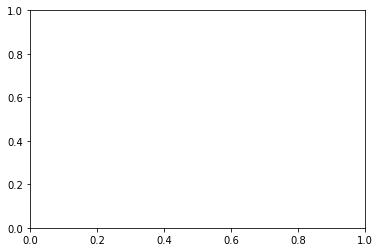

In [76]:
import matplotlib.pyplot as plt
%matplotlib inline
indices = hist_and_support(pca.weights, num_weights)

In [77]:
indices

array([300, 321,  25, 267, 120,  51, 366, 206, 279, 185])

In [82]:
pca1.controlset

[array([[ 3.44533781e-02,  2.51716432e-02, -5.63524535e-02,
          5.30185207e-02,  8.21306329e-02],
        [-5.81757972e-02, -3.55157335e-02, -7.55379879e-02,
         -5.23004682e-02,  2.17356779e-01],
        [-7.17478508e-02, -5.57309906e-02, -7.19920342e-02,
         -2.10161529e-03,  6.47424079e-02],
        [-2.92291191e-02, -6.76671882e-03,  8.57811628e-02,
          6.20068170e-03,  1.03154765e-01],
        [-8.12397578e-02,  9.22086183e-02, -8.96271559e-02,
         -4.08386709e-02,  2.22304111e-01],
        [ 8.39025743e-02, -2.34921661e-02,  2.61230741e-02,
         -9.11228862e-02,  1.71543225e-01],
        [ 4.11040034e-02, -2.38726601e-02,  3.17878312e-02,
          5.68408755e-02,  1.51684551e-01],
        [-9.82115850e-03, -1.85266631e-02, -1.48480956e-02,
         -9.20646360e-03,  1.82309411e-01],
        [ 7.06611174e-02,  2.98564909e-02,  1.07808536e-01,
          1.14568690e-02,  1.60877820e-01],
        [ 4.34703700e-02,  9.70871910e-03,  4.21771467e-03,
    

In [83]:

#pca1 = dill.load(open('../../../repos/randomized_controls/' + pcas[choice], 'rb'))
pca1 = dill.load(open(filename, 'rb'))
subweights = pca.weights[indices]
pca1.controlset = [pca1.controlset[i] for i in indices]
pca1.probs = list(np.array(subweights.T/sum(subweights)).T)
off_diagonals(pca1, scale)


TypeError: 'NoneType' object is not subscriptable

SUPPORT:0.9999444970986676
NUM CONTROLS: 10


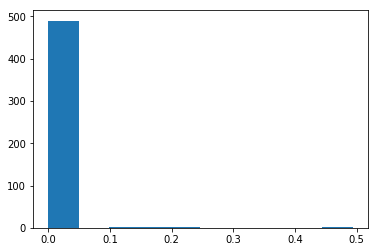

In [84]:
import matplotlib.pyplot as plt
num_weights0 = num_weights
%matplotlib inline
indices = hist_and_support(pca.weights_0, num_weights0)

SUPPORT:0.9999444970986676
NUM CONTROLS: 10
DOING COMBO [-0.0001, -0.0001, -0.0001, -0.0001, -0.0001]
DOING COMBO [-0.0001, -0.0001, -0.0001, 0.0001, -0.0001]
DOING COMBO [-0.0001, -0.0001, 0.0001, -0.0001, -0.0001]
DOING COMBO [-0.0001, -0.0001, 0.0001, 0.0001, -0.0001]
DOING COMBO [-0.0001, -0.0001, 0.0001, -0.0001, 0.0001]
DOING COMBO [-0.0001, -0.0001, 0.0001, 0.0001, 0.0001]
DOING COMBO [-0.0001, -0.0001, -0.0001, 0.0001, 0.0001]
DOING COMBO [-0.0001, -0.0001, -0.0001, -0.0001, 0.0001]
DOING COMBO [-0.0001, 0.0001, -0.0001, -0.0001, -0.0001]
DOING COMBO [-0.0001, 0.0001, 0.0001, -0.0001, -0.0001]
DOING COMBO [-0.0001, 0.0001, -0.0001, 0.0001, -0.0001]
DOING COMBO [-0.0001, 0.0001, 0.0001, 0.0001, -0.0001]
DOING COMBO [-0.0001, 0.0001, -0.0001, -0.0001, 0.0001]
DOING COMBO [-0.0001, 0.0001, 0.0001, 0.0001, 0.0001]
DOING COMBO [-0.0001, 0.0001, -0.0001, 0.0001, 0.0001]
DOING COMBO [-0.0001, 0.0001, 0.0001, -0.0001, 0.0001]
DOING COMBO [0.0001, -0.0001, -0.0001, -0.0001, -0.0001]
DOI

/home/anthony/.pyenv/versions/3.6.3/envs/personal/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


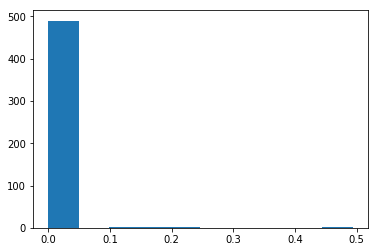

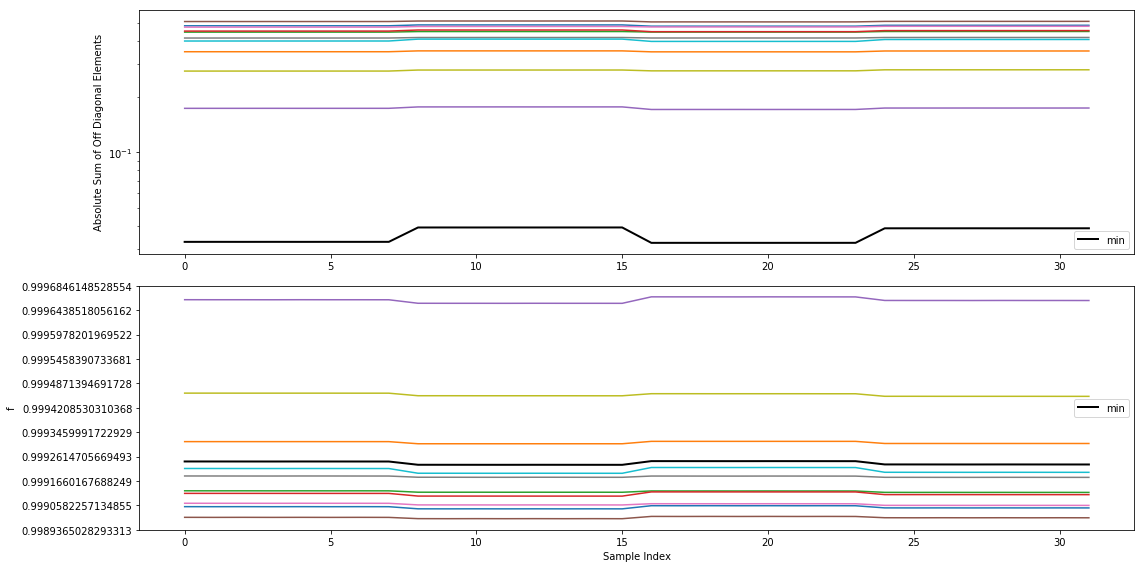

In [85]:
import matplotlib.pyplot as plt

#pca0 = dill.load(open('../../../repos/randomized_controls/' + pcas[choice], 'rb'))
pca0 = dill.load(open(filename, 'rb'))
indices = hist_and_support(pca.weights_0, num_weights0)
subweights = pca.weights_0[indices]
pca0.controlset = [pca0.controlset[i] for i in indices]
pca0.probs = list(np.array(subweights.T/sum(subweights)).T)
off_diagonals(pca0, scale*10)


In [ ]:
pca.seed

In [ ]:
off_diagonals2(pca1, pca0, scale/8)

In [90]:
%%bash 
ls ../data

pickled_controls228.pkl
pickled_controls245.pkl
pickled_controls261.pkl
__pycache__
raw_data
rb_data
README.md
report_pickled_controls228
report_pickled_controls245
report_pickled_controls261
Untitled.ipynb


In [96]:
old_pca = dill.load(open('../data/pickled_controls261.pkl', 'rb'))

In [98]:
old_pca.assign_weights()

Done with convex problem 1 out of 20
Done with convex problem 2 out of 20
Done with convex problem 3 out of 20
Done with convex problem 4 out of 20
Done with convex problem 5 out of 20
Done with convex problem 6 out of 20
Done with convex problem 7 out of 20
Done with convex problem 8 out of 20
Done with convex problem 9 out of 20
Done with convex problem 10 out of 20
Done with convex problem 11 out of 20
Done with convex problem 12 out of 20
Done with convex problem 13 out of 20
Done with convex problem 14 out of 20
Done with convex problem 15 out of 20
Done with convex problem 16 out of 20
Done with convex problem 17 out of 20
Done with convex problem 18 out of 20
Done with convex problem 19 out of 20
Done with convex problem 1 out of 20
Done with convex problem 2 out of 20
Done with convex problem 3 out of 20
Done with convex problem 4 out of 20
Done with convex problem 5 out of 20
Done with convex problem 6 out of 20
Done with convex problem 7 out of 20
Done with convex problem 8 o

In [102]:
filename = 'pickled_controls10.pkl'
dill.dump(old_pca, open(filename, 'wb'))

SUPPORT:0.9999928419224517
NUM CONTROLS: 10


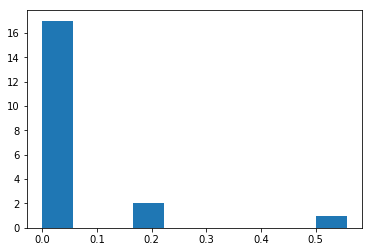

In [104]:
import matplotlib.pyplot as plt
pca = dill.load(open(filename, 'rb'))
num_weights0 = num_weights
%matplotlib inline
indices = hist_and_support(pca.weights_0, num_weights0)

DOING COMBO [-0.001, -0.00019999999999999998, -0.0006000000000000001, 0.0002000000000000001, -0.001]
DOING COMBO [-0.001, -0.001, -0.001, -0.001, -0.001]
DOING COMBO [-0.0006000000000000001, -0.001, 0.0006000000000000001, 0.0002000000000000001, -0.001]
DOING COMBO [-0.001, 0.0006000000000000001, 0.0002000000000000001, -0.001, -0.001]
DOING COMBO [-0.001, -0.001, -0.001, -0.001, -0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, -0.001, 0.0006000000000000001, 0.0002000000000000001, -0.0006000000000000001]
DOING COMBO [-0.001, -0.00019999999999999998, -0.0006000000000000001, 0.0002000000000000001, -0.0006000000000000001]
DOING COMBO [-0.001, 0.0006000000000000001, 0.0002000000000000001, -0.001, -0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, -0.001, 0.0006000000000000001, 0.0002000000000000001, -0.00019999999999999998]
DOING COMBO [-0.001, -0.001, -0.001, -0.001, -0.00019999999999999998]
DOING COMBO [-0.001, 0.0006000000000000001, 0.0002000000000000001, -0.001, -0.

DOING COMBO [-0.0006000000000000001, -0.001, 0.001, -0.001, 0.0002000000000000001]
DOING COMBO [-0.001, 0.0006000000000000001, 0.0002000000000000001, 0.0002000000000000001, 0.0002000000000000001]
DOING COMBO [-0.001, -0.001, -0.001, 0.0002000000000000001, 0.0002000000000000001]
DOING COMBO [-0.001, -0.00019999999999999998, -0.00019999999999999998, -0.001, 0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, -0.001, 0.001, -0.001, 0.0006000000000000001]
DOING COMBO [-0.001, 0.0006000000000000001, 0.0002000000000000001, 0.0002000000000000001, 0.0006000000000000001]
DOING COMBO [-0.001, -0.001, -0.001, 0.0002000000000000001, 0.0006000000000000001]
DOING COMBO [-0.001, -0.00019999999999999998, -0.00019999999999999998, -0.001, 0.001]
DOING COMBO [-0.0006000000000000001, -0.001, 0.001, -0.001, 0.001]
DOING COMBO [-0.001, 0.0006000000000000001, 0.0002000000000000001, 0.0002000000000000001, 0.001]
DOING COMBO [-0.001, -0.001, -0.001, 0.0002000000000000001, 0.001]
DOING COMBO [-0.001, -0

DOING COMBO [-0.001, -0.00019999999999999998, -0.00019999999999999998, 0.0006000000000000001, -0.0006000000000000001]
DOING COMBO [-0.001, 0.0006000000000000001, 0.0006000000000000001, -0.0006000000000000001, -0.0006000000000000001]
DOING COMBO [-0.001, -0.001, -0.0006000000000000001, -0.0006000000000000001, -0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, -0.001, 0.001, 0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [-0.001, -0.00019999999999999998, -0.00019999999999999998, 0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [-0.001, 0.0006000000000000001, 0.0006000000000000001, -0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [-0.001, -0.001, -0.0006000000000000001, -0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [-0.0006000000000000001, -0.001, 0.001, 0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [-0.001, 0.0006000000000000001, 0.0006000000000000001, -0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [-0.0

DOING COMBO [-0.001, -0.001, -0.0006000000000000001, 0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [-0.0006000000000000001, -0.0006000000000000001, -0.001, -0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [-0.001, -0.00019999999999999998, 0.0002000000000000001, -0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [-0.001, 0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [-0.001, -0.001, -0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, -0.0006000000000000001, -0.001, -0.0006000000000000001, 0.001]
DOING COMBO [-0.001, -0.00019999999999999998, 0.0002000000000000001, -0.0006000000000000001, 0.001]
DOING COMBO [-0.001, 0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, 0.001]
DOING COMBO [-0.001, -0.001, -0.0006000000000000001, 0.0006000000000000001, 0.001]
DOING COMBO [-0.0006000000000000001, -0.0006000000000000001, -0.001, -0.00019

DOING COMBO [-0.001, -0.00019999999999999998, 0.0002000000000000001, 0.001, -0.001]
DOING COMBO [-0.001, 0.0006000000000000001, 0.001, -0.00019999999999999998, -0.001]
DOING COMBO [-0.0006000000000000001, -0.0006000000000000001, -0.001, 0.001, -0.0006000000000000001]
DOING COMBO [-0.001, -0.001, -0.00019999999999999998, -0.00019999999999999998, -0.0006000000000000001]
DOING COMBO [-0.001, -0.00019999999999999998, 0.0002000000000000001, 0.001, -0.0006000000000000001]
DOING COMBO [-0.001, 0.0006000000000000001, 0.001, -0.00019999999999999998, -0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, -0.0006000000000000001, -0.001, 0.001, -0.00019999999999999998]
DOING COMBO [-0.001, -0.001, -0.00019999999999999998, -0.00019999999999999998, -0.00019999999999999998]
DOING COMBO [-0.001, -0.00019999999999999998, 0.0002000000000000001, 0.001, -0.00019999999999999998]
DOING COMBO [-0.001, 0.0006000000000000001, 0.001, -0.00019999999999999998, -0.00019999999999999998]
DOING COMBO [-0.000600

DOING COMBO [-0.001, 0.0006000000000000001, 0.001, 0.001, -0.00019999999999999998]
DOING COMBO [-0.001, -0.001, -0.00019999999999999998, 0.001, 0.0002000000000000001]
DOING COMBO [-0.001, -0.00019999999999999998, 0.0006000000000000001, -0.00019999999999999998, 0.0002000000000000001]
DOING COMBO [-0.0006000000000000001, -0.0006000000000000001, -0.0006000000000000001, -0.00019999999999999998, 0.0006000000000000001]
DOING COMBO [-0.001, 0.0006000000000000001, 0.001, 0.001, 0.0002000000000000001]
DOING COMBO [-0.001, -0.001, -0.00019999999999999998, 0.001, 0.0006000000000000001]
DOING COMBO [-0.001, -0.00019999999999999998, 0.0006000000000000001, -0.00019999999999999998, 0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, -0.0006000000000000001, -0.0006000000000000001, -0.00019999999999999998, 0.001]
DOING COMBO [-0.001, 0.0006000000000000001, 0.001, 0.001, 0.0006000000000000001]
DOING COMBO [-0.001, -0.001, -0.00019999999999999998, 0.001, 0.001]
DOING COMBO [-0.001, -0.00019999999

DOING COMBO [-0.001, 0.001, -0.001, -0.00019999999999999998, 0.001]
DOING COMBO [-0.001, -0.001, 0.0002000000000000001, 0.0002000000000000001, -0.001]
DOING COMBO [-0.001, -0.00019999999999999998, 0.001, -0.001, -0.001]
DOING COMBO [-0.0006000000000000001, -0.0006000000000000001, -0.00019999999999999998, -0.001, -0.00019999999999999998]
DOING COMBO [-0.001, 0.001, -0.001, 0.0002000000000000001, -0.001]
DOING COMBO [-0.001, -0.001, 0.0002000000000000001, 0.0002000000000000001, -0.0006000000000000001]
DOING COMBO [-0.001, -0.00019999999999999998, 0.001, -0.001, -0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, -0.0006000000000000001, -0.00019999999999999998, -0.001, 0.0002000000000000001]
DOING COMBO [-0.001, 0.001, -0.001, 0.0002000000000000001, -0.0006000000000000001]
DOING COMBO [-0.001, -0.001, 0.0002000000000000001, 0.0002000000000000001, -0.00019999999999999998]
DOING COMBO [-0.001, -0.00019999999999999998, 0.001, -0.001, -0.00019999999999999998]
DOING COMBO [-0.00060000

DOING COMBO [-0.001, 0.001, -0.0006000000000000001, -0.001, 0.0002000000000000001]
DOING COMBO [-0.001, -0.001, 0.0006000000000000001, -0.001, 0.0006000000000000001]
DOING COMBO [-0.001, -0.00019999999999999998, 0.001, 0.0002000000000000001, 0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, -0.0006000000000000001, -0.00019999999999999998, 0.0006000000000000001, -0.001]
DOING COMBO [-0.001, 0.001, -0.0006000000000000001, -0.001, 0.0006000000000000001]
DOING COMBO [-0.001, -0.001, 0.0006000000000000001, -0.001, 0.001]
DOING COMBO [-0.001, -0.00019999999999999998, 0.001, 0.0002000000000000001, 0.001]
DOING COMBO [-0.0006000000000000001, -0.0006000000000000001, -0.00019999999999999998, 0.0006000000000000001, -0.0006000000000000001]
DOING COMBO [-0.001, 0.001, -0.0006000000000000001, -0.001, 0.001]
DOING COMBO [-0.001, -0.001, 0.0006000000000000001, -0.0006000000000000001, -0.001]
DOING COMBO [-0.001, -0.00019999999999999998, 0.001, 0.0006000000000000001, -0.001]
DOING COMBO [-0.0

DOING COMBO [-0.0006000000000000001, -0.0006000000000000001, 0.0002000000000000001, -0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [-0.001, 0.0002000000000000001, -0.001, -0.0006000000000000001, -0.0006000000000000001]
DOING COMBO [-0.001, 0.001, -0.0006000000000000001, 0.0006000000000000001, -0.0006000000000000001]
DOING COMBO [-0.001, -0.001, 0.0006000000000000001, 0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [-0.0006000000000000001, -0.0006000000000000001, 0.0002000000000000001, -0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [-0.001, 0.0002000000000000001, -0.001, -0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [-0.001, 0.001, -0.0006000000000000001, 0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [-0.001, -0.001, 0.0006000000000000001, 0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [-0.0006000000000000001, -0.0006000000000000001, 0.0002000000000000001, -0.0006000000000000001, 0.001]
DOING COMBO [-0.001, 0.00

DOING COMBO [-0.001, 0.0002000000000000001, -0.001, 0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, -0.0006000000000000001, 0.0002000000000000001, 0.001, -0.0006000000000000001]
DOING COMBO [-0.001, -0.001, 0.001, -0.0006000000000000001, 0.001]
DOING COMBO [-0.001, 0.001, -0.00019999999999999998, -0.0006000000000000001, 0.001]
DOING COMBO [-0.001, 0.0002000000000000001, -0.001, 0.0006000000000000001, 0.001]
DOING COMBO [-0.001, -0.001, 0.001, -0.00019999999999999998, -0.001]
DOING COMBO [-0.0006000000000000001, -0.0006000000000000001, 0.0002000000000000001, 0.001, -0.00019999999999999998]
DOING COMBO [-0.001, 0.001, -0.00019999999999999998, -0.00019999999999999998, -0.001]
DOING COMBO [-0.001, 0.0002000000000000001, -0.001, 0.001, -0.001]
DOING COMBO [-0.001, -0.001, 0.001, -0.00019999999999999998, -0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, -0.0006000000000000001, 0.0002000000000000001, 0.001, 0.0002000000000000001]
DOING COMBO [-0.0

DOING COMBO [-0.001, -0.001, 0.001, 0.001, -0.00019999999999999998]
DOING COMBO [-0.001, 0.001, -0.00019999999999999998, 0.001, -0.00019999999999999998]
DOING COMBO [-0.001, 0.0002000000000000001, -0.0006000000000000001, -0.00019999999999999998, -0.00019999999999999998]
DOING COMBO [-0.0006000000000000001, -0.0006000000000000001, 0.0006000000000000001, -0.00019999999999999998, 0.001]
DOING COMBO [-0.001, -0.001, 0.001, 0.001, 0.0002000000000000001]
DOING COMBO [-0.001, 0.001, -0.00019999999999999998, 0.001, 0.0002000000000000001]
DOING COMBO [-0.001, 0.0002000000000000001, -0.0006000000000000001, -0.00019999999999999998, 0.0002000000000000001]
DOING COMBO [-0.0006000000000000001, -0.0006000000000000001, 0.0006000000000000001, 0.0002000000000000001, -0.001]
DOING COMBO [-0.001, -0.001, 0.001, 0.001, 0.0006000000000000001]
DOING COMBO [-0.001, 0.001, -0.00019999999999999998, 0.001, 0.0006000000000000001]
DOING COMBO [-0.001, 0.0002000000000000001, -0.0006000000000000001, -0.0001999999999

DOING COMBO [-0.0006000000000000001, -0.0006000000000000001, 0.001, -0.001, -0.0006000000000000001]
DOING COMBO [-0.001, -0.0006000000000000001, -0.001, -0.00019999999999999998, 0.001]
DOING COMBO [-0.001, 0.001, 0.0002000000000000001, -0.00019999999999999998, 0.001]
DOING COMBO [-0.001, 0.0002000000000000001, -0.0006000000000000001, 0.001, 0.001]
DOING COMBO [-0.0006000000000000001, -0.0006000000000000001, 0.001, -0.001, -0.00019999999999999998]
DOING COMBO [-0.001, 0.001, 0.0002000000000000001, 0.0002000000000000001, -0.001]
DOING COMBO [-0.001, -0.0006000000000000001, -0.001, 0.0002000000000000001, -0.001]
DOING COMBO [-0.001, 0.0002000000000000001, -0.00019999999999999998, -0.001, -0.001]
DOING COMBO [-0.0006000000000000001, -0.0006000000000000001, 0.001, -0.001, 0.0002000000000000001]
DOING COMBO [-0.001, 0.001, 0.0002000000000000001, 0.0002000000000000001, -0.0006000000000000001]
DOING COMBO [-0.001, -0.0006000000000000001, -0.001, 0.0002000000000000001, -0.0006000000000000001]
D

DOING COMBO [-0.001, 0.001, 0.0006000000000000001, -0.001, -0.00019999999999999998]
DOING COMBO [-0.001, 0.0002000000000000001, -0.00019999999999999998, 0.0002000000000000001, -0.00019999999999999998]
DOING COMBO [-0.001, -0.0006000000000000001, -0.0006000000000000001, -0.001, -0.00019999999999999998]
DOING COMBO [-0.0006000000000000001, -0.0006000000000000001, 0.001, 0.0002000000000000001, 0.001]
DOING COMBO [-0.001, 0.001, 0.0006000000000000001, -0.001, 0.0002000000000000001]
DOING COMBO [-0.001, 0.0002000000000000001, -0.00019999999999999998, 0.0002000000000000001, 0.0002000000000000001]
DOING COMBO [-0.001, -0.0006000000000000001, -0.0006000000000000001, -0.001, 0.0002000000000000001]
DOING COMBO [-0.0006000000000000001, -0.0006000000000000001, 0.001, 0.0006000000000000001, -0.001]
DOING COMBO [-0.001, 0.001, 0.0006000000000000001, -0.001, 0.0006000000000000001]
DOING COMBO [-0.001, 0.0002000000000000001, -0.00019999999999999998, 0.0002000000000000001, 0.0006000000000000001]
DOING 

DOING COMBO [-0.001, -0.0006000000000000001, -0.0006000000000000001, 0.0002000000000000001, 0.0006000000000000001]
DOING COMBO [-0.001, 0.0002000000000000001, 0.0002000000000000001, -0.001, 0.001]
DOING COMBO [-0.001, 0.001, 0.0006000000000000001, 0.0002000000000000001, 0.001]
DOING COMBO [-0.0006000000000000001, -0.00019999999999999998, -0.001, -0.0006000000000000001, -0.0006000000000000001]
DOING COMBO [-0.001, -0.0006000000000000001, -0.0006000000000000001, 0.0002000000000000001, 0.001]
DOING COMBO [-0.001, 0.0002000000000000001, 0.0002000000000000001, -0.0006000000000000001, -0.001]
DOING COMBO [-0.001, 0.001, 0.0006000000000000001, 0.0006000000000000001, -0.001]
DOING COMBO [-0.0006000000000000001, -0.00019999999999999998, -0.001, -0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [-0.001, -0.0006000000000000001, -0.0006000000000000001, 0.0006000000000000001, -0.001]
DOING COMBO [-0.001, 0.0002000000000000001, 0.0002000000000000001, -0.0006000000000000001, -0.00060000000

DOING COMBO [-0.001, -0.0006000000000000001, -0.00019999999999999998, -0.0006000000000000001, -0.0006000000000000001]
DOING COMBO [-0.001, 0.001, 0.001, -0.0006000000000000001, -0.0006000000000000001]
DOING COMBO [-0.001, 0.0002000000000000001, 0.0002000000000000001, 0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [-0.0006000000000000001, -0.00019999999999999998, -0.001, 0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [-0.001, -0.0006000000000000001, -0.00019999999999999998, -0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [-0.001, 0.001, 0.001, -0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [-0.001, 0.0002000000000000001, 0.0002000000000000001, 0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [-0.0006000000000000001, -0.00019999999999999998, -0.001, 0.0006000000000000001, 0.001]
DOING COMBO [-0.001, -0.0006000000000000001, -0.00019999999999999998, -0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [-0.001, 0.001, 0.001, 

DOING COMBO [-0.001, 0.0002000000000000001, 0.0006000000000000001, -0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, -0.00019999999999999998, -0.0006000000000000001, -0.00019999999999999998, -0.001]
DOING COMBO [-0.001, -0.0006000000000000001, -0.00019999999999999998, 0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [-0.001, 0.001, 0.001, 0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [-0.001, 0.0002000000000000001, 0.0006000000000000001, -0.0006000000000000001, 0.001]
DOING COMBO [-0.0006000000000000001, -0.00019999999999999998, -0.0006000000000000001, -0.00019999999999999998, -0.0006000000000000001]
DOING COMBO [-0.001, -0.0006000000000000001, -0.00019999999999999998, 0.0006000000000000001, 0.001]
DOING COMBO [-0.001, 0.001, 0.001, 0.0006000000000000001, 0.001]
DOING COMBO [-0.001, 0.0002000000000000001, 0.0006000000000000001, -0.00019999999999999998, -0.001]
DOING COMBO [-0.0006000000000000001, -0.00019999999999999998, -0.0006000

DOING COMBO [-0.0006000000000000001, -0.001, -0.001, -0.0006000000000000001, 0.001]
DOING COMBO [-0.001, -0.0006000000000000001, 0.0002000000000000001, -0.00019999999999999998, -0.001]
DOING COMBO [-0.0006000000000000001, -0.00019999999999999998, -0.0006000000000000001, 0.001, -0.00019999999999999998]
DOING COMBO [-0.001, 0.0002000000000000001, 0.0006000000000000001, 0.001, -0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, -0.001, -0.001, -0.00019999999999999998, -0.001]
DOING COMBO [-0.001, -0.0006000000000000001, 0.0002000000000000001, -0.00019999999999999998, -0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, -0.00019999999999999998, -0.0006000000000000001, 0.001, 0.0002000000000000001]
DOING COMBO [-0.001, 0.0002000000000000001, 0.0006000000000000001, 0.001, -0.00019999999999999998]
DOING COMBO [-0.0006000000000000001, -0.001, -0.001, -0.00019999999999999998, -0.0006000000000000001]
DOING COMBO [-0.001, -0.0006000000000000001, 0.0002000000000000001, -0.00019999

DOING COMBO [-0.0006000000000000001, -0.001, -0.001, 0.001, -0.0006000000000000001]
DOING COMBO [-0.001, -0.0006000000000000001, 0.0002000000000000001, 0.001, -0.00019999999999999998]
DOING COMBO [-0.0006000000000000001, -0.00019999999999999998, -0.00019999999999999998, -0.00019999999999999998, 0.0006000000000000001]
DOING COMBO [-0.001, 0.0002000000000000001, 0.001, -0.00019999999999999998, 0.0002000000000000001]
DOING COMBO [-0.0006000000000000001, -0.001, -0.001, 0.001, -0.00019999999999999998]
DOING COMBO [-0.001, -0.0006000000000000001, 0.0002000000000000001, 0.001, 0.0002000000000000001]
DOING COMBO [-0.0006000000000000001, -0.00019999999999999998, -0.00019999999999999998, -0.00019999999999999998, 0.001]
DOING COMBO [-0.001, 0.0002000000000000001, 0.001, -0.00019999999999999998, 0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, -0.001, -0.001, 0.001, 0.0002000000000000001]
DOING COMBO [-0.001, -0.0006000000000000001, 0.0002000000000000001, 0.001, 0.0006000000000000001]


DOING COMBO [-0.001, 0.0002000000000000001, 0.001, 0.001, 0.0006000000000000001]
DOING COMBO [-0.001, -0.0006000000000000001, 0.0006000000000000001, -0.00019999999999999998, 0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, -0.001, -0.0006000000000000001, -0.00019999999999999998, 0.0002000000000000001]
DOING COMBO [-0.0006000000000000001, -0.00019999999999999998, 0.0002000000000000001, -0.001, -0.001]
DOING COMBO [-0.001, 0.0002000000000000001, 0.001, 0.001, 0.001]
DOING COMBO [-0.001, -0.0006000000000000001, 0.0006000000000000001, -0.00019999999999999998, 0.001]
DOING COMBO [-0.0006000000000000001, -0.001, -0.0006000000000000001, -0.00019999999999999998, 0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, -0.00019999999999999998, 0.0002000000000000001, -0.001, -0.0006000000000000001]
DOING COMBO [-0.001, 0.0006000000000000001, -0.001, -0.001, -0.001]
DOING COMBO [-0.001, -0.0006000000000000001, 0.0006000000000000001, 0.0002000000000000001, -0.001]
DOING COMBO [-0.000

DOING COMBO [-0.0006000000000000001, -0.001, -0.0006000000000000001, 0.001, 0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, -0.00019999999999999998, 0.0002000000000000001, 0.0002000000000000001, -0.0006000000000000001]
DOING COMBO [-0.001, 0.0006000000000000001, -0.001, 0.0002000000000000001, -0.001]
DOING COMBO [-0.001, -0.0006000000000000001, 0.001, -0.001, -0.001]
DOING COMBO [-0.0006000000000000001, -0.001, -0.0006000000000000001, 0.001, 0.001]
DOING COMBO [-0.0006000000000000001, -0.00019999999999999998, 0.0002000000000000001, 0.0002000000000000001, -0.00019999999999999998]
DOING COMBO [-0.001, 0.0006000000000000001, -0.001, 0.0002000000000000001, -0.0006000000000000001]
DOING COMBO [-0.001, -0.0006000000000000001, 0.001, -0.001, -0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, -0.001, -0.00019999999999999998, -0.001, -0.001]
DOING COMBO [-0.0006000000000000001, -0.00019999999999999998, 0.0002000000000000001, 0.0002000000000000001, 0.0002000000000000001]
DO

DOING COMBO [-0.001, 0.0006000000000000001, -0.0006000000000000001, -0.001, -0.00019999999999999998]
DOING COMBO [-0.001, -0.0006000000000000001, 0.001, 0.0002000000000000001, -0.00019999999999999998]
DOING COMBO [-0.0006000000000000001, -0.001, -0.00019999999999999998, 0.0002000000000000001, -0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, -0.00019999999999999998, 0.0006000000000000001, -0.001, 0.0006000000000000001]
DOING COMBO [-0.001, 0.0006000000000000001, -0.0006000000000000001, -0.001, 0.0002000000000000001]
DOING COMBO [-0.001, -0.0006000000000000001, 0.001, 0.0002000000000000001, 0.0002000000000000001]
DOING COMBO [-0.0006000000000000001, -0.001, -0.00019999999999999998, 0.0002000000000000001, -0.00019999999999999998]
DOING COMBO [-0.0006000000000000001, -0.00019999999999999998, 0.0006000000000000001, -0.001, 0.001]
DOING COMBO [-0.001, 0.0006000000000000001, -0.0006000000000000001, -0.001, 0.0006000000000000001]
DOING COMBO [-0.001, -0.0006000000000000001, 0.001, 

DOING COMBO [-0.0006000000000000001, -0.001, 0.0002000000000000001, -0.001, -0.00019999999999999998]
DOING COMBO [-0.001, 0.0006000000000000001, -0.0006000000000000001, 0.0002000000000000001, 0.0006000000000000001]
DOING COMBO [-0.001, -0.00019999999999999998, -0.001, -0.001, 0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, -0.00019999999999999998, 0.0006000000000000001, 0.0002000000000000001, 0.001]
DOING COMBO [-0.0006000000000000001, -0.001, 0.0002000000000000001, -0.001, 0.0002000000000000001]
DOING COMBO [-0.001, 0.0006000000000000001, -0.0006000000000000001, 0.0002000000000000001, 0.001]
DOING COMBO [-0.001, -0.00019999999999999998, -0.001, -0.001, 0.001]
DOING COMBO [-0.0006000000000000001, -0.00019999999999999998, 0.0006000000000000001, 0.0006000000000000001, -0.001]
DOING COMBO [-0.0006000000000000001, -0.001, 0.0002000000000000001, -0.001, 0.0006000000000000001]
DOING COMBO [-0.001, 0.0006000000000000001, -0.0006000000000000001, 0.0006000000000000001, -0.001]
DOING

DOING COMBO [-0.0006000000000000001, -0.00019999999999999998, 0.001, -0.0006000000000000001, -0.001]
DOING COMBO [-0.001, 0.0006000000000000001, -0.00019999999999999998, -0.0006000000000000001, -0.001]
DOING COMBO [-0.001, -0.00019999999999999998, -0.001, 0.0006000000000000001, -0.001]
DOING COMBO [-0.0006000000000000001, -0.001, 0.0002000000000000001, 0.0002000000000000001, 0.001]
DOING COMBO [-0.0006000000000000001, -0.00019999999999999998, 0.001, -0.0006000000000000001, -0.0006000000000000001]
DOING COMBO [-0.001, 0.0006000000000000001, -0.00019999999999999998, -0.0006000000000000001, -0.0006000000000000001]
DOING COMBO [-0.001, -0.00019999999999999998, -0.001, 0.0006000000000000001, -0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, -0.001, 0.0002000000000000001, 0.0006000000000000001, -0.001]
DOING COMBO [-0.0006000000000000001, -0.00019999999999999998, 0.001, -0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [-0.001, 0.0006000000000000001, -0.0001999999999999

DOING COMBO [-0.0006000000000000001, -0.00019999999999999998, 0.001, 0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [-0.001, 0.0006000000000000001, -0.00019999999999999998, 0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [-0.001, -0.00019999999999999998, -0.0006000000000000001, -0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [-0.0006000000000000001, -0.001, 0.0006000000000000001, -0.0006000000000000001, -0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, -0.00019999999999999998, 0.001, 0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [-0.001, 0.0006000000000000001, -0.00019999999999999998, 0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [-0.001, -0.00019999999999999998, -0.0006000000000000001, -0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [-0.0006000000000000001, -0.001, 0.0006000000000000001, -0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [-0.0006000000000000001, -0.00019999999999999998, 0.001

DOING COMBO [-0.00019999999999999998, 0.0002000000000000001, 0.0006000000000000001, 0.0006000000000000001, -0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, -0.0006000000000000001, 0.0002000000000000001, -0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [-0.0006000000000000001, 0.001, -0.0006000000000000001, 0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [-0.0006000000000000001, 0.0002000000000000001, -0.001, -0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, 0.0002000000000000001, 0.0006000000000000001, 0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [-0.0006000000000000001, 0.001, -0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, -0.0006000000000000001, 0.0002000000000000001, -0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, 0.0002000000000000001, -0.001, -0.0006000000000000001, 0.001]
DOING COMBO [-0.000199999999999

DOING COMBO [-0.00019999999999999998, -0.0006000000000000001, 0.0002000000000000001, 0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [-0.0006000000000000001, 0.0002000000000000001, -0.001, 0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, 0.0002000000000000001, 0.001, -0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [-0.00019999999999999998, -0.0006000000000000001, 0.0002000000000000001, 0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, 0.001, -0.00019999999999999998, -0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, 0.0002000000000000001, -0.001, 0.0006000000000000001, 0.001]
DOING COMBO [-0.00019999999999999998, 0.0002000000000000001, 0.001, -0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [-0.0006000000000000001, 0.001, -0.00019999999999999998, -0.0006000000000000001, 0.001]
DOING COMBO [-0.00019999999999999998, -0.0006000000000000001, 0.00020000000000

DOING COMBO [-0.00019999999999999998, 0.0002000000000000001, 0.001, 0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [-0.0006000000000000001, 0.001, -0.00019999999999999998, 0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, -0.0006000000000000001, 0.0006000000000000001, -0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, 0.0002000000000000001, -0.0006000000000000001, -0.0006000000000000001, 0.001]
DOING COMBO [-0.00019999999999999998, 0.0002000000000000001, 0.001, 0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [-0.0006000000000000001, 0.001, -0.00019999999999999998, 0.0006000000000000001, 0.001]
DOING COMBO [-0.00019999999999999998, -0.0006000000000000001, 0.0006000000000000001, -0.0006000000000000001, 0.001]
DOING COMBO [-0.0006000000000000001, 0.0002000000000000001, -0.0006000000000000001, -0.00019999999999999998, -0.001]
DOING COMBO [-0.00019999999999999998, 0.0002000000000000001, 0.001, 0.000600

DOING COMBO [-0.0006000000000000001, 0.001, 0.0002000000000000001, -0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, -0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, 0.0002000000000000001, -0.0006000000000000001, 0.0006000000000000001, 0.001]
DOING COMBO [-0.00019999999999999998, 0.0006000000000000001, -0.001, -0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [-0.0006000000000000001, 0.001, 0.0002000000000000001, -0.0006000000000000001, 0.001]
DOING COMBO [-0.00019999999999999998, -0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, 0.001]
DOING COMBO [-0.0006000000000000001, 0.0002000000000000001, -0.0006000000000000001, 0.001, -0.001]
DOING COMBO [-0.00019999999999999998, 0.0006000000000000001, -0.001, -0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, 0.001, 0.0002000000000000001, -0.00019999999999999998, -0.00

DOING COMBO [-0.0006000000000000001, 0.0002000000000000001, -0.00019999999999999998, -0.0006000000000000001, 0.001]
DOING COMBO [-0.00019999999999999998, 0.0006000000000000001, -0.001, 0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [-0.0006000000000000001, 0.001, 0.0002000000000000001, 0.0006000000000000001, 0.001]
DOING COMBO [-0.00019999999999999998, -0.0006000000000000001, 0.001, -0.0006000000000000001, 0.001]
DOING COMBO [-0.0006000000000000001, 0.0002000000000000001, -0.00019999999999999998, -0.00019999999999999998, -0.001]
DOING COMBO [-0.00019999999999999998, 0.0006000000000000001, -0.001, 0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, 0.001, 0.0002000000000000001, 0.001, -0.001]
DOING COMBO [-0.00019999999999999998, -0.0006000000000000001, 0.001, -0.00019999999999999998, -0.001]
DOING COMBO [-0.0006000000000000001, 0.0002000000000000001, -0.00019999999999999998, -0.00019999999999999998, -0.0006000000000000001]
DOING COMBO [-0.00019

DOING COMBO [-0.00019999999999999998, 0.0006000000000000001, -0.0006000000000000001, -0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [-0.00019999999999999998, -0.0006000000000000001, 0.001, 0.0006000000000000001, 0.001]
DOING COMBO [-0.0006000000000000001, 0.0002000000000000001, -0.00019999999999999998, 0.001, -0.001]
DOING COMBO [-0.0006000000000000001, 0.001, 0.0006000000000000001, -0.00019999999999999998, -0.001]
DOING COMBO [-0.00019999999999999998, 0.0006000000000000001, -0.0006000000000000001, -0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, -0.0006000000000000001, 0.001, 0.001, -0.001]
DOING COMBO [-0.0006000000000000001, 0.0002000000000000001, -0.00019999999999999998, 0.001, -0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, 0.001, 0.0006000000000000001, -0.00019999999999999998, -0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, 0.0006000000000000001, -0.0006000000000000001, -0.0006000000000000001, 0.001]
DOING

DOING COMBO [-0.00019999999999999998, -0.00019999999999999998, -0.001, -0.0006000000000000001, 0.001]
DOING COMBO [-0.0006000000000000001, 0.0002000000000000001, 0.0002000000000000001, -0.00019999999999999998, -0.001]
DOING COMBO [-0.0006000000000000001, 0.001, 0.0006000000000000001, 0.001, -0.001]
DOING COMBO [-0.00019999999999999998, 0.0006000000000000001, -0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, -0.00019999999999999998, -0.001, -0.00019999999999999998, -0.001]
DOING COMBO [-0.0006000000000000001, 0.0002000000000000001, 0.0002000000000000001, -0.00019999999999999998, -0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, 0.001, 0.0006000000000000001, 0.001, -0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, 0.0006000000000000001, -0.0006000000000000001, 0.0006000000000000001, 0.001]
DOING COMBO [-0.00019999999999999998, -0.00019999999999999998, -0.001, -0.00019999999999999998, -0.0006000000000000001]


DOING COMBO [-0.00019999999999999998, 0.0006000000000000001, -0.00019999999999999998, -0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, -0.00019999999999999998, -0.001, 0.001, -0.001]
DOING COMBO [-0.0006000000000000001, 0.0002000000000000001, 0.0002000000000000001, 0.001, -0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, 0.001, 0.001, -0.00019999999999999998, -0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, 0.0006000000000000001, -0.00019999999999999998, -0.0006000000000000001, 0.001]
DOING COMBO [-0.00019999999999999998, -0.00019999999999999998, -0.001, 0.001, -0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, 0.0002000000000000001, 0.0002000000000000001, 0.001, -0.00019999999999999998]
DOING COMBO [-0.0006000000000000001, 0.001, 0.001, -0.00019999999999999998, -0.00019999999999999998]
DOING COMBO [-0.00019999999999999998, 0.0006000000000000001, -0.00019999999999999998, -0.00019999999999999998, -0.001]
DOING COMBO [

DOING COMBO [-0.00019999999999999998, -0.00019999999999999998, -0.0006000000000000001, -0.00019999999999999998, -0.001]
DOING COMBO [-0.0006000000000000001, 0.0002000000000000001, 0.0006000000000000001, -0.00019999999999999998, -0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, 0.001, 0.001, 0.001, -0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, 0.0006000000000000001, -0.00019999999999999998, 0.0006000000000000001, 0.001]
DOING COMBO [-0.00019999999999999998, -0.00019999999999999998, -0.0006000000000000001, -0.00019999999999999998, -0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, 0.0002000000000000001, 0.0006000000000000001, -0.00019999999999999998, -0.00019999999999999998]
DOING COMBO [-0.0006000000000000001, 0.001, 0.001, 0.001, -0.00019999999999999998]
DOING COMBO [-0.00019999999999999998, 0.0006000000000000001, -0.00019999999999999998, 0.001, -0.001]
DOING COMBO [-0.00019999999999999998, -0.00019999999999999998, -0.0006000000000000001, -0.0001999

DOING COMBO [-0.0006000000000000001, 0.0002000000000000001, 0.0006000000000000001, 0.001, -0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, -0.001, -0.001, -0.00019999999999999998, -0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, 0.0006000000000000001, 0.0002000000000000001, -0.0006000000000000001, 0.001]
DOING COMBO [-0.00019999999999999998, -0.00019999999999999998, -0.0006000000000000001, 0.001, -0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, 0.0002000000000000001, 0.0006000000000000001, 0.001, -0.00019999999999999998]
DOING COMBO [-0.00019999999999999998, -0.001, -0.001, -0.00019999999999999998, -0.00019999999999999998]
DOING COMBO [-0.00019999999999999998, 0.0006000000000000001, 0.0002000000000000001, -0.00019999999999999998, -0.001]
DOING COMBO [-0.00019999999999999998, -0.00019999999999999998, -0.0006000000000000001, 0.001, -0.00019999999999999998]
DOING COMBO [-0.0006000000000000001, 0.0002000000000000001, 0.0006000000000000001, 0.001, 0.000

DOING COMBO [-0.00019999999999999998, 0.0006000000000000001, 0.0002000000000000001, 0.0006000000000000001, 0.001]
DOING COMBO [-0.00019999999999999998, -0.00019999999999999998, -0.00019999999999999998, -0.00019999999999999998, -0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, 0.0002000000000000001, 0.001, -0.00019999999999999998, -0.00019999999999999998]
DOING COMBO [-0.00019999999999999998, -0.001, -0.001, 0.001, -0.00019999999999999998]
DOING COMBO [-0.00019999999999999998, 0.0006000000000000001, 0.0002000000000000001, 0.001, -0.001]
DOING COMBO [-0.00019999999999999998, -0.00019999999999999998, -0.00019999999999999998, -0.00019999999999999998, -0.00019999999999999998]
DOING COMBO [-0.0006000000000000001, 0.0002000000000000001, 0.001, -0.00019999999999999998, 0.0002000000000000001]
DOING COMBO [-0.00019999999999999998, -0.001, -0.001, 0.001, 0.0002000000000000001]
DOING COMBO [-0.00019999999999999998, 0.0006000000000000001, 0.0002000000000000001, 0.001, -0.0006000000000000

DOING COMBO [-0.0006000000000000001, 0.0002000000000000001, 0.001, 0.001, -0.00019999999999999998]
DOING COMBO [-0.00019999999999999998, -0.00019999999999999998, -0.00019999999999999998, 0.001, -0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, -0.001, -0.0006000000000000001, -0.00019999999999999998, -0.00019999999999999998]
DOING COMBO [-0.00019999999999999998, 0.0006000000000000001, 0.0006000000000000001, -0.00019999999999999998, -0.001]
DOING COMBO [-0.0006000000000000001, 0.0002000000000000001, 0.001, 0.001, 0.0002000000000000001]
DOING COMBO [-0.00019999999999999998, -0.001, -0.0006000000000000001, -0.00019999999999999998, 0.0002000000000000001]
DOING COMBO [-0.00019999999999999998, -0.00019999999999999998, -0.00019999999999999998, 0.001, -0.00019999999999999998]
DOING COMBO [-0.00019999999999999998, 0.0006000000000000001, 0.0006000000000000001, -0.00019999999999999998, -0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, -0.001, -0.0006000000000000001, -0.0001

DOING COMBO [-0.0006000000000000001, 0.0006000000000000001, -0.001, -0.00019999999999999998, -0.00019999999999999998]
DOING COMBO [-0.00019999999999999998, -0.00019999999999999998, 0.0002000000000000001, -0.00019999999999999998, -0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, 0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, 0.001]
DOING COMBO [-0.00019999999999999998, -0.001, -0.0006000000000000001, 0.001, 0.0002000000000000001]
DOING COMBO [-0.0006000000000000001, 0.0006000000000000001, -0.001, -0.00019999999999999998, 0.0002000000000000001]
DOING COMBO [-0.00019999999999999998, 0.0006000000000000001, 0.0006000000000000001, 0.001, -0.001]
DOING COMBO [-0.00019999999999999998, -0.00019999999999999998, 0.0002000000000000001, -0.00019999999999999998, -0.00019999999999999998]
DOING COMBO [-0.00019999999999999998, -0.001, -0.0006000000000000001, 0.001, 0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, 0.0006000000000000001, -0.001, -0.00019999999

DOING COMBO [-0.00019999999999999998, 0.0006000000000000001, 0.001, -0.0006000000000000001, 0.001]
DOING COMBO [-0.0006000000000000001, 0.0006000000000000001, -0.001, 0.001, 0.0002000000000000001]
DOING COMBO [-0.00019999999999999998, -0.001, -0.00019999999999999998, -0.00019999999999999998, 0.0002000000000000001]
DOING COMBO [-0.00019999999999999998, -0.00019999999999999998, 0.0002000000000000001, 0.001, -0.00019999999999999998]
DOING COMBO [-0.00019999999999999998, 0.0006000000000000001, 0.001, -0.00019999999999999998, -0.001]
DOING COMBO [-0.0006000000000000001, 0.0006000000000000001, -0.001, 0.001, 0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, -0.001, -0.00019999999999999998, -0.00019999999999999998, 0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, -0.00019999999999999998, 0.0002000000000000001, 0.001, 0.0002000000000000001]
DOING COMBO [-0.00019999999999999998, 0.0006000000000000001, 0.001, -0.00019999999999999998, -0.0006000000000000001]
DOING COMBO [-0

DOING COMBO [-0.00019999999999999998, 0.0006000000000000001, 0.001, 0.0006000000000000001, 0.001]
DOING COMBO [-0.00019999999999999998, -0.00019999999999999998, 0.0006000000000000001, -0.00019999999999999998, -0.00019999999999999998]
DOING COMBO [-0.00019999999999999998, -0.001, -0.00019999999999999998, 0.001, 0.0002000000000000001]
DOING COMBO [-0.0006000000000000001, 0.0006000000000000001, -0.0006000000000000001, -0.00019999999999999998, 0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, 0.0006000000000000001, 0.001, 0.001, -0.001]
DOING COMBO [-0.00019999999999999998, -0.00019999999999999998, 0.0006000000000000001, -0.00019999999999999998, 0.0002000000000000001]
DOING COMBO [-0.00019999999999999998, -0.001, -0.00019999999999999998, 0.001, 0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, 0.0006000000000000001, -0.0006000000000000001, -0.00019999999999999998, 0.001]
DOING COMBO [-0.00019999999999999998, 0.0006000000000000001, 0.001, 0.001, -0.0006000000000000001]


DOING COMBO [-0.0006000000000000001, 0.0006000000000000001, -0.0006000000000000001, 0.001, 0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, 0.001, -0.001, -0.00019999999999999998, -0.001]
DOING COMBO [-0.00019999999999999998, -0.001, 0.0002000000000000001, -0.00019999999999999998, 0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, -0.00019999999999999998, 0.0006000000000000001, 0.001, 0.0002000000000000001]
DOING COMBO [-0.0006000000000000001, 0.0006000000000000001, -0.0006000000000000001, 0.001, 0.001]
DOING COMBO [-0.00019999999999999998, 0.001, -0.001, -0.00019999999999999998, -0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, -0.001, 0.0002000000000000001, -0.00019999999999999998, 0.001]
DOING COMBO [-0.00019999999999999998, -0.00019999999999999998, 0.0006000000000000001, 0.001, 0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, 0.0006000000000000001, -0.00019999999999999998, -0.001, -0.001]
DOING COMBO [-0.00019999999999999998, 0.001, -0.0

DOING COMBO [-0.0006000000000000001, 0.0006000000000000001, -0.00019999999999999998, -0.00019999999999999998, 0.001]
DOING COMBO [-0.00019999999999999998, -0.00019999999999999998, 0.001, -0.00019999999999999998, 0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, -0.001, 0.0002000000000000001, 0.001, 0.001]
DOING COMBO [-0.00019999999999999998, 0.001, -0.001, 0.001, -0.00019999999999999998]
DOING COMBO [-0.0006000000000000001, 0.0006000000000000001, -0.00019999999999999998, 0.0002000000000000001, -0.001]
DOING COMBO [-0.00019999999999999998, -0.00019999999999999998, 0.001, -0.00019999999999999998, 0.001]
DOING COMBO [-0.00019999999999999998, -0.001, 0.0006000000000000001, -0.001, -0.001]
DOING COMBO [-0.00019999999999999998, 0.001, -0.001, 0.001, 0.0002000000000000001]
DOING COMBO [-0.0006000000000000001, 0.0006000000000000001, -0.00019999999999999998, 0.0002000000000000001, -0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, -0.00019999999999999998, 0.001, 0.0002000

DOING COMBO [-0.0006000000000000001, 0.0006000000000000001, 0.0002000000000000001, -0.001, -0.001]
DOING COMBO [-0.00019999999999999998, -0.00019999999999999998, 0.001, 0.001, 0.001]
DOING COMBO [-0.00019999999999999998, 0.001, -0.0006000000000000001, -0.00019999999999999998, 0.0002000000000000001]
DOING COMBO [-0.00019999999999999998, -0.001, 0.0006000000000000001, 0.0002000000000000001, -0.001]
DOING COMBO [-0.0006000000000000001, 0.0006000000000000001, 0.0002000000000000001, -0.001, -0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, 0.0002000000000000001, -0.001, -0.001, -0.001]
DOING COMBO [-0.00019999999999999998, 0.001, -0.0006000000000000001, -0.00019999999999999998, 0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, -0.001, 0.0006000000000000001, 0.0002000000000000001, -0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, 0.0006000000000000001, 0.0002000000000000001, -0.001, -0.00019999999999999998]
DOING COMBO [-0.00019999999999999998, 0.00020000000

DOING COMBO [-0.00019999999999999998, -0.001, 0.001, -0.001, -0.001]
DOING COMBO [-0.00019999999999999998, 0.001, -0.0006000000000000001, 0.001, 0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, 0.0006000000000000001, 0.0002000000000000001, 0.0002000000000000001, -0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, 0.0002000000000000001, -0.001, 0.0002000000000000001, -0.001]
DOING COMBO [-0.00019999999999999998, -0.001, 0.001, -0.001, -0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, 0.001, -0.0006000000000000001, 0.001, 0.001]
DOING COMBO [-0.0006000000000000001, 0.0006000000000000001, 0.0002000000000000001, 0.0002000000000000001, -0.00019999999999999998]
DOING COMBO [-0.00019999999999999998, 0.0002000000000000001, -0.001, 0.0002000000000000001, -0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, -0.001, 0.001, -0.001, -0.00019999999999999998]
DOING COMBO [-0.00019999999999999998, 0.001, -0.00019999999999999998, -0.001, -0.001]
DOING COMBO [-0

DOING COMBO [-0.00019999999999999998, -0.001, 0.001, 0.0002000000000000001, -0.00019999999999999998]
DOING COMBO [-0.00019999999999999998, 0.0002000000000000001, -0.0006000000000000001, -0.001, -0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, 0.001, -0.00019999999999999998, 0.0002000000000000001, -0.001]
DOING COMBO [-0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, -0.001, 0.0002000000000000001]
DOING COMBO [-0.00019999999999999998, -0.001, 0.001, 0.0002000000000000001, 0.0002000000000000001]
DOING COMBO [-0.00019999999999999998, 0.0002000000000000001, -0.0006000000000000001, -0.001, -0.00019999999999999998]
DOING COMBO [-0.00019999999999999998, 0.001, -0.00019999999999999998, 0.0002000000000000001, -0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, -0.001, 0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, -0.001, 0.001, 0.0002000000000000001, 0.0006000000000000001]
DOING COMBO [-0.0001

DOING COMBO [-0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, 0.0002000000000000001, 0.0002000000000000001]
DOING COMBO [-0.00019999999999999998, 0.0002000000000000001, -0.0006000000000000001, 0.0002000000000000001, -0.00019999999999999998]
DOING COMBO [-0.00019999999999999998, -0.0006000000000000001, -0.001, -0.001, 0.0002000000000000001]
DOING COMBO [-0.00019999999999999998, 0.001, 0.0002000000000000001, -0.001, -0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, 0.0002000000000000001, 0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, -0.0006000000000000001, -0.001, -0.001, 0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, 0.0002000000000000001, -0.0006000000000000001, 0.0002000000000000001, 0.0002000000000000001]
DOING COMBO [-0.00019999999999999998, 0.001, 0.0002000000000000001, -0.001, -0.00019999999999999998]
DOING COMBO [-0.0006000000000000001, 0.0006000000000000001, 0.0006000000000

DOING COMBO [-0.00019999999999999998, 0.0002000000000000001, -0.00019999999999999998, -0.001, -0.00019999999999999998]
DOING COMBO [-0.00019999999999999998, 0.001, 0.0002000000000000001, 0.0002000000000000001, -0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, 0.0006000000000000001, 0.001, -0.001, 0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, -0.0006000000000000001, -0.001, 0.0002000000000000001, 0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, 0.0002000000000000001, -0.00019999999999999998, -0.001, 0.0002000000000000001]
DOING COMBO [-0.00019999999999999998, 0.001, 0.0002000000000000001, 0.0002000000000000001, -0.00019999999999999998]
DOING COMBO [-0.0006000000000000001, 0.0006000000000000001, 0.001, -0.001, 0.001]
DOING COMBO [-0.00019999999999999998, -0.0006000000000000001, -0.001, 0.0002000000000000001, 0.001]
DOING COMBO [-0.00019999999999999998, 0.0002000000000000001, -0.00019999999999999998, -0.001, 0.0006000000000000001]
DOING COMBO [-0.0001

DOING COMBO [-0.00019999999999999998, -0.0006000000000000001, -0.0006000000000000001, -0.001, 0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, 0.001, 0.0006000000000000001, -0.001, -0.00019999999999999998]
DOING COMBO [-0.00019999999999999998, 0.0002000000000000001, -0.00019999999999999998, 0.0002000000000000001, 0.0002000000000000001]
DOING COMBO [-0.0006000000000000001, 0.0006000000000000001, 0.001, 0.0002000000000000001, 0.001]
DOING COMBO [-0.00019999999999999998, 0.001, 0.0006000000000000001, -0.001, 0.0002000000000000001]
DOING COMBO [-0.00019999999999999998, -0.0006000000000000001, -0.0006000000000000001, -0.001, 0.001]
DOING COMBO [-0.00019999999999999998, 0.0002000000000000001, -0.00019999999999999998, 0.0002000000000000001, 0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, 0.0006000000000000001, 0.001, 0.0006000000000000001, -0.001]
DOING COMBO [-0.00019999999999999998, 0.001, 0.0006000000000000001, -0.001, 0.0006000000000000001]
DOING COMBO [-0.00019999

DOING COMBO [-0.0006000000000000001, 0.001, -0.001, -0.001, 0.001]
DOING COMBO [-0.00019999999999999998, 0.0002000000000000001, 0.0002000000000000001, -0.001, 0.0002000000000000001]
DOING COMBO [-0.00019999999999999998, -0.0006000000000000001, -0.0006000000000000001, 0.0002000000000000001, 0.001]
DOING COMBO [-0.00019999999999999998, 0.001, 0.0006000000000000001, 0.0002000000000000001, 0.0002000000000000001]
DOING COMBO [-0.0006000000000000001, 0.001, -0.001, -0.0006000000000000001, -0.001]
DOING COMBO [-0.00019999999999999998, 0.0002000000000000001, 0.0002000000000000001, -0.001, 0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, -0.0006000000000000001, -0.0006000000000000001, 0.0006000000000000001, -0.001]
DOING COMBO [-0.00019999999999999998, 0.001, 0.0006000000000000001, 0.0002000000000000001, 0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, 0.0002000000000000001, 0.0002000000000000001, -0.001, 0.001]
DOING COMBO [-0.0006000000000000001, 0.001, -0.001, -0.0006

DOING COMBO [-0.0006000000000000001, 0.001, -0.001, 0.0006000000000000001, -0.001]
DOING COMBO [-0.00019999999999999998, 0.001, 0.001, -0.001, 0.0002000000000000001]
DOING COMBO [-0.00019999999999999998, -0.0006000000000000001, -0.00019999999999999998, -0.0006000000000000001, -0.001]
DOING COMBO [-0.00019999999999999998, 0.0002000000000000001, 0.0002000000000000001, 0.0002000000000000001, 0.001]
DOING COMBO [-0.0006000000000000001, 0.001, -0.001, 0.0006000000000000001, -0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, 0.001, 0.001, -0.001, 0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, -0.0006000000000000001, -0.00019999999999999998, -0.0006000000000000001, -0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, 0.0002000000000000001, 0.0002000000000000001, 0.0006000000000000001, -0.001]
DOING COMBO [-0.0006000000000000001, 0.001, -0.001, 0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [-0.00019999999999999998, 0.001, 0.001, -0.001, 0.001]
DO

DOING COMBO [-0.00019999999999999998, 0.001, 0.001, 0.0002000000000000001, 0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, -0.0006000000000000001, -0.00019999999999999998, 0.0006000000000000001, -0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, 0.001, -0.0006000000000000001, -0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [-0.00019999999999999998, 0.0002000000000000001, 0.0006000000000000001, -0.0006000000000000001, -0.0006000000000000001]
DOING COMBO [-0.00019999999999999998, 0.001, 0.001, 0.0002000000000000001, 0.001]
DOING COMBO [-0.00019999999999999998, -0.0006000000000000001, -0.00019999999999999998, 0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [-0.0006000000000000001, 0.001, -0.0006000000000000001, -0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [-0.00019999999999999998, 0.0002000000000000001, 0.0006000000000000001, -0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [-0.00019999999999999998, 0.001, 0.001, 0.

DOING COMBO [0.0006000000000000001, -0.001, 0.0006000000000000001, 0.0002000000000000001, 0.001]
DOING COMBO [0.0002000000000000001, -0.00019999999999999998, -0.0006000000000000001, 0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [0.0002000000000000001, 0.0006000000000000001, 0.0002000000000000001, -0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [0.0002000000000000001, -0.001, -0.001, -0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [0.0006000000000000001, -0.001, 0.0006000000000000001, 0.0006000000000000001, -0.001]
DOING COMBO [0.0002000000000000001, -0.00019999999999999998, -0.0006000000000000001, 0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [0.0002000000000000001, 0.0006000000000000001, 0.0002000000000000001, -0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [0.0002000000000000001, -0.001, -0.001, -0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [0.0006000000000000001, -0.001, 0.0006000000000000001, 0.00060000000000

DOING COMBO [0.0002000000000000001, -0.00019999999999999998, -0.00019999999999999998, -0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [0.0002000000000000001, -0.001, -0.001, 0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [0.0002000000000000001, 0.0006000000000000001, 0.0002000000000000001, 0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [0.0006000000000000001, -0.001, 0.001, -0.0006000000000000001, -0.0006000000000000001]
DOING COMBO [0.0002000000000000001, -0.00019999999999999998, -0.00019999999999999998, -0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [0.0002000000000000001, -0.001, -0.001, 0.0006000000000000001, 0.001]
DOING COMBO [0.0002000000000000001, 0.0006000000000000001, 0.0002000000000000001, 0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [0.0006000000000000001, -0.001, 0.001, -0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [0.0002000000000000001, -0.00019999999999999998, -0.00019999999999999998, -0.0006000000

DOING COMBO [0.0002000000000000001, 0.0006000000000000001, 0.0006000000000000001, -0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [0.0002000000000000001, -0.001, -0.0006000000000000001, -0.0006000000000000001, 0.001]
DOING COMBO [0.0006000000000000001, -0.001, 0.001, 0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [0.0002000000000000001, -0.00019999999999999998, -0.00019999999999999998, 0.0006000000000000001, 0.001]
DOING COMBO [0.0002000000000000001, 0.0006000000000000001, 0.0006000000000000001, -0.0006000000000000001, 0.001]
DOING COMBO [0.0002000000000000001, -0.001, -0.0006000000000000001, -0.00019999999999999998, -0.001]
DOING COMBO [0.0006000000000000001, -0.001, 0.001, 0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [0.0002000000000000001, -0.00019999999999999998, -0.00019999999999999998, 0.001, -0.001]
DOING COMBO [0.0002000000000000001, 0.0006000000000000001, 0.0006000000000000001, -0.00019999999999999998, -0.001]
DOING COMBO [0.000200000000000

DOING COMBO [0.0002000000000000001, -0.00019999999999999998, 0.0002000000000000001, -0.0006000000000000001, 0.001]
DOING COMBO [0.0002000000000000001, 0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, 0.001]
DOING COMBO [0.0002000000000000001, -0.001, -0.0006000000000000001, 0.001, -0.001]
DOING COMBO [0.0006000000000000001, -0.0006000000000000001, -0.001, -0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [0.0002000000000000001, -0.00019999999999999998, 0.0002000000000000001, -0.00019999999999999998, -0.001]
DOING COMBO [0.0002000000000000001, 0.0006000000000000001, 0.0006000000000000001, 0.001, -0.001]
DOING COMBO [0.0002000000000000001, -0.001, -0.0006000000000000001, 0.001, -0.0006000000000000001]
DOING COMBO [0.0006000000000000001, -0.0006000000000000001, -0.001, -0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [0.0002000000000000001, -0.00019999999999999998, 0.0002000000000000001, -0.00019999999999999998, -0.0006000000000000001]
DOING COMBO [0

DOING COMBO [0.0006000000000000001, -0.0006000000000000001, -0.001, 0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [0.0002000000000000001, -0.00019999999999999998, 0.0002000000000000001, 0.001, -0.001]
DOING COMBO [0.0002000000000000001, -0.001, -0.00019999999999999998, -0.00019999999999999998, -0.0006000000000000001]
DOING COMBO [0.0002000000000000001, 0.0006000000000000001, 0.001, -0.00019999999999999998, -0.001]
DOING COMBO [0.0006000000000000001, -0.0006000000000000001, -0.001, 0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [0.0002000000000000001, -0.00019999999999999998, 0.0002000000000000001, 0.001, -0.0006000000000000001]
DOING COMBO [0.0002000000000000001, -0.001, -0.00019999999999999998, -0.00019999999999999998, -0.00019999999999999998]
DOING COMBO [0.0002000000000000001, 0.0006000000000000001, 0.001, -0.00019999999999999998, -0.0006000000000000001]
DOING COMBO [0.0006000000000000001, -0.0006000000000000001, -0.001, 0.0006000000000000001, 0.001]
DOING COM

DOING COMBO [0.0002000000000000001, 0.0006000000000000001, 0.001, 0.001, -0.001]
DOING COMBO [0.0002000000000000001, -0.00019999999999999998, 0.0006000000000000001, -0.00019999999999999998, -0.0006000000000000001]
DOING COMBO [0.0006000000000000001, -0.0006000000000000001, -0.0006000000000000001, -0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [0.0002000000000000001, -0.001, -0.00019999999999999998, 0.001, -0.00019999999999999998]
DOING COMBO [0.0002000000000000001, 0.0006000000000000001, 0.001, 0.001, -0.0006000000000000001]
DOING COMBO [0.0002000000000000001, -0.00019999999999999998, 0.0006000000000000001, -0.00019999999999999998, -0.00019999999999999998]
DOING COMBO [0.0006000000000000001, -0.0006000000000000001, -0.0006000000000000001, -0.0006000000000000001, 0.001]
DOING COMBO [0.0002000000000000001, -0.001, -0.00019999999999999998, 0.001, 0.0002000000000000001]
DOING COMBO [0.0002000000000000001, 0.0006000000000000001, 0.001, 0.001, -0.00019999999999999998]
DOING COMBO

DOING COMBO [0.0002000000000000001, -0.001, 0.0002000000000000001, -0.00019999999999999998, -0.00019999999999999998]
DOING COMBO [0.0006000000000000001, -0.0006000000000000001, -0.0006000000000000001, 0.0006000000000000001, 0.001]
DOING COMBO [0.0002000000000000001, 0.001, -0.001, -0.00019999999999999998, -0.0006000000000000001]
DOING COMBO [0.0002000000000000001, -0.00019999999999999998, 0.0006000000000000001, 0.001, -0.00019999999999999998]
DOING COMBO [0.0002000000000000001, -0.001, 0.0002000000000000001, -0.00019999999999999998, 0.0002000000000000001]
DOING COMBO [0.0006000000000000001, -0.0006000000000000001, -0.0006000000000000001, 0.001, -0.001]
DOING COMBO [0.0002000000000000001, 0.001, -0.001, -0.00019999999999999998, -0.00019999999999999998]
DOING COMBO [0.0002000000000000001, -0.00019999999999999998, 0.0006000000000000001, 0.001, 0.0002000000000000001]
DOING COMBO [0.0002000000000000001, -0.001, 0.0002000000000000001, -0.00019999999999999998, 0.0006000000000000001]
DOING COM

DOING COMBO [0.0002000000000000001, -0.001, 0.0002000000000000001, 0.001, 0.0006000000000000001]
DOING COMBO [0.0006000000000000001, -0.0006000000000000001, -0.00019999999999999998, -0.00019999999999999998, -0.001]
DOING COMBO [0.0002000000000000001, 0.001, -0.001, 0.001, 0.0002000000000000001]
DOING COMBO [0.0002000000000000001, -0.001, 0.0002000000000000001, 0.001, 0.001]
DOING COMBO [0.0002000000000000001, -0.00019999999999999998, 0.001, -0.00019999999999999998, 0.0006000000000000001]
DOING COMBO [0.0006000000000000001, -0.0006000000000000001, -0.00019999999999999998, -0.00019999999999999998, -0.0006000000000000001]
DOING COMBO [0.0002000000000000001, 0.001, -0.001, 0.001, 0.0006000000000000001]
DOING COMBO [0.0002000000000000001, -0.001, 0.0006000000000000001, -0.001, -0.001]
DOING COMBO [0.0002000000000000001, -0.00019999999999999998, 0.001, -0.00019999999999999998, 0.001]
DOING COMBO [0.0006000000000000001, -0.0006000000000000001, -0.00019999999999999998, -0.00019999999999999998,

DOING COMBO [0.0002000000000000001, -0.001, 0.0006000000000000001, -0.00019999999999999998, 0.001]
DOING COMBO [0.0002000000000000001, -0.00019999999999999998, 0.001, 0.001, 0.0006000000000000001]
DOING COMBO [0.0002000000000000001, 0.001, -0.0006000000000000001, -0.00019999999999999998, 0.0006000000000000001]
DOING COMBO [0.0006000000000000001, -0.0006000000000000001, -0.00019999999999999998, 0.001, -0.00019999999999999998]
DOING COMBO [0.0002000000000000001, -0.001, 0.0006000000000000001, 0.0002000000000000001, -0.001]
DOING COMBO [0.0002000000000000001, -0.00019999999999999998, 0.001, 0.001, 0.001]
DOING COMBO [0.0002000000000000001, 0.001, -0.0006000000000000001, -0.00019999999999999998, 0.001]
DOING COMBO [0.0006000000000000001, -0.0006000000000000001, -0.00019999999999999998, 0.001, 0.0002000000000000001]
DOING COMBO [0.0002000000000000001, -0.001, 0.0006000000000000001, 0.0002000000000000001, -0.0006000000000000001]
DOING COMBO [0.0002000000000000001, 0.0002000000000000001, -0.0

DOING COMBO [0.0002000000000000001, -0.001, 0.001, -0.001, -0.001]
DOING COMBO [0.0002000000000000001, 0.001, -0.0006000000000000001, 0.001, 0.001]
DOING COMBO [0.0006000000000000001, -0.0006000000000000001, 0.0002000000000000001, -0.00019999999999999998, 0.0002000000000000001]
DOING COMBO [0.0002000000000000001, 0.0002000000000000001, -0.001, 0.0002000000000000001, -0.001]
DOING COMBO [0.0002000000000000001, -0.001, 0.001, -0.001, -0.0006000000000000001]
DOING COMBO [0.0002000000000000001, 0.001, -0.00019999999999999998, -0.001, -0.001]
DOING COMBO [0.0006000000000000001, -0.0006000000000000001, 0.0002000000000000001, -0.00019999999999999998, 0.0006000000000000001]
DOING COMBO [0.0002000000000000001, 0.0002000000000000001, -0.001, 0.0002000000000000001, -0.0006000000000000001]
DOING COMBO [0.0002000000000000001, -0.001, 0.001, -0.001, -0.00019999999999999998]
DOING COMBO [0.0002000000000000001, 0.001, -0.00019999999999999998, -0.001, -0.0006000000000000001]
DOING COMBO [0.000600000000

DOING COMBO [0.0002000000000000001, -0.001, 0.001, 0.0002000000000000001, -0.00019999999999999998]
DOING COMBO [0.0002000000000000001, 0.0002000000000000001, -0.0006000000000000001, -0.001, -0.0006000000000000001]
DOING COMBO [0.0002000000000000001, 0.001, -0.00019999999999999998, 0.0002000000000000001, -0.0006000000000000001]
DOING COMBO [0.0006000000000000001, -0.0006000000000000001, 0.0002000000000000001, 0.001, 0.001]
DOING COMBO [0.0002000000000000001, -0.001, 0.001, 0.0002000000000000001, 0.0002000000000000001]
DOING COMBO [0.0002000000000000001, 0.0002000000000000001, -0.0006000000000000001, -0.001, -0.00019999999999999998]
DOING COMBO [0.0002000000000000001, 0.001, -0.00019999999999999998, 0.0002000000000000001, -0.00019999999999999998]
DOING COMBO [0.0006000000000000001, -0.0006000000000000001, 0.0006000000000000001, -0.001, -0.001]
DOING COMBO [0.0002000000000000001, -0.001, 0.001, 0.0002000000000000001, 0.0006000000000000001]
DOING COMBO [0.0002000000000000001, 0.00020000000

DOING COMBO [0.0002000000000000001, -0.0006000000000000001, -0.001, -0.001, 0.0002000000000000001]
DOING COMBO [0.0002000000000000001, 0.0002000000000000001, -0.0006000000000000001, 0.0002000000000000001, -0.00019999999999999998]
DOING COMBO [0.0002000000000000001, 0.001, 0.0002000000000000001, -0.001, -0.00019999999999999998]
DOING COMBO [0.0006000000000000001, -0.0006000000000000001, 0.0006000000000000001, 0.0002000000000000001, -0.001]
DOING COMBO [0.0002000000000000001, -0.0006000000000000001, -0.001, -0.001, 0.0006000000000000001]
DOING COMBO [0.0002000000000000001, 0.0002000000000000001, -0.0006000000000000001, 0.0002000000000000001, 0.0002000000000000001]
DOING COMBO [0.0006000000000000001, -0.0006000000000000001, 0.0006000000000000001, 0.0002000000000000001, -0.0006000000000000001]
DOING COMBO [0.0002000000000000001, -0.0006000000000000001, -0.001, -0.001, 0.001]
DOING COMBO [0.0002000000000000001, 0.001, 0.0002000000000000001, -0.001, 0.0002000000000000001]
DOING COMBO [0.0002

DOING COMBO [0.0002000000000000001, 0.0002000000000000001, -0.00019999999999999998, -0.001, -0.00019999999999999998]
DOING COMBO [0.0002000000000000001, -0.0006000000000000001, -0.001, 0.0002000000000000001, 0.0006000000000000001]
DOING COMBO [0.0006000000000000001, -0.0006000000000000001, 0.001, -0.001, -0.001]
DOING COMBO [0.0002000000000000001, 0.001, 0.0002000000000000001, 0.0002000000000000001, -0.00019999999999999998]
DOING COMBO [0.0002000000000000001, 0.0002000000000000001, -0.00019999999999999998, -0.001, 0.0002000000000000001]
DOING COMBO [0.0002000000000000001, -0.0006000000000000001, -0.001, 0.0002000000000000001, 0.001]
DOING COMBO [0.0006000000000000001, -0.0006000000000000001, 0.001, -0.001, -0.0006000000000000001]
DOING COMBO [0.0002000000000000001, 0.001, 0.0002000000000000001, 0.0002000000000000001, 0.0002000000000000001]
DOING COMBO [0.0002000000000000001, 0.0002000000000000001, -0.00019999999999999998, -0.001, 0.0006000000000000001]
DOING COMBO [0.000200000000000000

DOING COMBO [0.0002000000000000001, 0.001, 0.0006000000000000001, -0.001, 0.0002000000000000001]
DOING COMBO [0.0002000000000000001, 0.0002000000000000001, -0.00019999999999999998, 0.0002000000000000001, 0.0002000000000000001]
DOING COMBO [0.0002000000000000001, -0.0006000000000000001, -0.0006000000000000001, -0.001, 0.001]
DOING COMBO [0.0006000000000000001, -0.0006000000000000001, 0.001, 0.0002000000000000001, -0.0006000000000000001]
DOING COMBO [0.0002000000000000001, -0.0006000000000000001, -0.0006000000000000001, -0.0006000000000000001, -0.001]
DOING COMBO [0.0002000000000000001, 0.001, 0.0006000000000000001, -0.001, 0.0006000000000000001]
DOING COMBO [0.0002000000000000001, 0.0002000000000000001, -0.00019999999999999998, 0.0002000000000000001, 0.0006000000000000001]
DOING COMBO [0.0006000000000000001, -0.0006000000000000001, 0.001, 0.0002000000000000001, -0.00019999999999999998]
DOING COMBO [0.0002000000000000001, 0.001, 0.0006000000000000001, -0.001, 0.001]
DOING COMBO [0.000200

DOING COMBO [0.0002000000000000001, 0.001, 0.0006000000000000001, 0.0002000000000000001, 0.0002000000000000001]
DOING COMBO [0.0002000000000000001, 0.0002000000000000001, 0.0002000000000000001, -0.001, 0.0002000000000000001]
DOING COMBO [0.0006000000000000001, -0.00019999999999999998, -0.001, -0.001, -0.0006000000000000001]
DOING COMBO [0.0002000000000000001, -0.0006000000000000001, -0.0006000000000000001, 0.0006000000000000001, -0.001]
DOING COMBO [0.0002000000000000001, 0.001, 0.0006000000000000001, 0.0002000000000000001, 0.0006000000000000001]
DOING COMBO [0.0002000000000000001, 0.0002000000000000001, 0.0002000000000000001, -0.001, 0.0006000000000000001]
DOING COMBO [0.0006000000000000001, -0.00019999999999999998, -0.001, -0.001, -0.00019999999999999998]
DOING COMBO [0.0002000000000000001, -0.0006000000000000001, -0.0006000000000000001, 0.0006000000000000001, -0.0006000000000000001]
DOING COMBO [0.0002000000000000001, 0.001, 0.0006000000000000001, 0.0002000000000000001, 0.001]
DOING

DOING COMBO [0.0006000000000000001, -0.00019999999999999998, -0.001, 0.0002000000000000001, -0.0006000000000000001]
DOING COMBO [0.0002000000000000001, 0.001, 0.001, -0.001, 0.0006000000000000001]
DOING COMBO [0.0002000000000000001, 0.0002000000000000001, 0.0002000000000000001, 0.0002000000000000001, 0.0006000000000000001]
DOING COMBO [0.0002000000000000001, -0.0006000000000000001, -0.00019999999999999998, -0.0006000000000000001, -0.0006000000000000001]
DOING COMBO [0.0006000000000000001, -0.00019999999999999998, -0.001, 0.0002000000000000001, -0.00019999999999999998]
DOING COMBO [0.0002000000000000001, 0.001, 0.001, -0.001, 0.001]
DOING COMBO [0.0002000000000000001, 0.0002000000000000001, 0.0002000000000000001, 0.0002000000000000001, 0.001]
DOING COMBO [0.0002000000000000001, -0.0006000000000000001, -0.00019999999999999998, -0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [0.0006000000000000001, -0.00019999999999999998, -0.001, 0.0002000000000000001, 0.0002000000000000001]

DOING COMBO [0.0002000000000000001, -0.0006000000000000001, -0.00019999999999999998, 0.0006000000000000001, -0.0006000000000000001]
DOING COMBO [0.0006000000000000001, -0.00019999999999999998, -0.0006000000000000001, -0.001, -0.00019999999999999998]
DOING COMBO [0.0002000000000000001, 0.001, 0.001, 0.0002000000000000001, 0.001]
DOING COMBO [0.0002000000000000001, 0.0002000000000000001, 0.0006000000000000001, -0.001, 0.001]
DOING COMBO [0.0002000000000000001, -0.0006000000000000001, -0.00019999999999999998, 0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [0.0006000000000000001, -0.00019999999999999998, -0.0006000000000000001, -0.001, 0.0002000000000000001]
DOING COMBO [0.0002000000000000001, 0.001, 0.001, 0.0006000000000000001, -0.001]
DOING COMBO [0.0002000000000000001, 0.0002000000000000001, 0.0006000000000000001, -0.0006000000000000001, -0.001]
DOING COMBO [0.0002000000000000001, -0.0006000000000000001, -0.00019999999999999998, 0.0006000000000000001, 0.0002000000000000001

DOING COMBO [0.0006000000000000001, -0.001, -0.001, -0.001, 0.001]
DOING COMBO [0.0002000000000000001, 0.0002000000000000001, 0.0006000000000000001, 0.0002000000000000001, 0.001]
DOING COMBO [0.0002000000000000001, -0.0006000000000000001, 0.0002000000000000001, -0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [0.0006000000000000001, -0.00019999999999999998, -0.0006000000000000001, 0.0002000000000000001, 0.0002000000000000001]
DOING COMBO [0.0006000000000000001, -0.001, -0.001, -0.0006000000000000001, -0.001]
DOING COMBO [0.0002000000000000001, 0.0002000000000000001, 0.0006000000000000001, 0.0006000000000000001, -0.001]
DOING COMBO [0.0002000000000000001, -0.0006000000000000001, 0.0002000000000000001, -0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [0.0006000000000000001, -0.00019999999999999998, -0.0006000000000000001, 0.0002000000000000001, 0.0006000000000000001]
DOING COMBO [0.0006000000000000001, -0.001, -0.001, -0.0006000000000000001, -0.0006000000000000001]


DOING COMBO [0.0002000000000000001, -0.0006000000000000001, 0.0002000000000000001, 0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [0.0006000000000000001, -0.00019999999999999998, -0.00019999999999999998, -0.001, 0.0002000000000000001]
DOING COMBO [0.0006000000000000001, -0.001, -0.001, 0.0006000000000000001, -0.001]
DOING COMBO [0.0002000000000000001, 0.0002000000000000001, 0.001, -0.0006000000000000001, -0.001]
DOING COMBO [0.0002000000000000001, -0.0006000000000000001, 0.0002000000000000001, 0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [0.0006000000000000001, -0.00019999999999999998, -0.00019999999999999998, -0.001, 0.0006000000000000001]
DOING COMBO [0.0006000000000000001, -0.001, -0.001, 0.0006000000000000001, -0.0006000000000000001]
DOING COMBO [0.0002000000000000001, 0.0002000000000000001, 0.001, -0.0006000000000000001, -0.0006000000000000001]
DOING COMBO [0.0006000000000000001, -0.00019999999999999998, -0.00019999999999999998, -0.001, 0.001]
DOING COMBO

DOING COMBO [0.0002000000000000001, 0.0002000000000000001, 0.001, 0.0006000000000000001, -0.001]
DOING COMBO [0.0002000000000000001, -0.0006000000000000001, 0.0006000000000000001, -0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [0.0006000000000000001, -0.00019999999999999998, -0.00019999999999999998, 0.0002000000000000001, 0.0006000000000000001]
DOING COMBO [0.0006000000000000001, -0.001, -0.0006000000000000001, -0.0006000000000000001, -0.0006000000000000001]
DOING COMBO [0.0002000000000000001, 0.0002000000000000001, 0.001, 0.0006000000000000001, -0.0006000000000000001]
DOING COMBO [0.0002000000000000001, -0.0006000000000000001, 0.0006000000000000001, -0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [0.0006000000000000001, -0.00019999999999999998, -0.00019999999999999998, 0.0002000000000000001, 0.001]
DOING COMBO [0.0006000000000000001, -0.001, -0.0006000000000000001, -0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [0.0002000000000000001, 0.00020000000

DOING COMBO [0.0006000000000000001, -0.00019999999999999998, 0.0002000000000000001, -0.001, 0.0006000000000000001]
DOING COMBO [0.0002000000000000001, -0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [0.0006000000000000001, -0.001, -0.0006000000000000001, 0.0006000000000000001, -0.0006000000000000001]
DOING COMBO [0.0002000000000000001, 0.0006000000000000001, -0.001, -0.0006000000000000001, -0.0006000000000000001]
DOING COMBO [0.0006000000000000001, -0.00019999999999999998, 0.0002000000000000001, -0.001, 0.001]
DOING COMBO [0.0002000000000000001, -0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [0.0006000000000000001, -0.001, -0.0006000000000000001, 0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [0.0002000000000000001, 0.0006000000000000001, -0.001, -0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [0.0006000000000000001, -0.00019999999999999998, 0.000

DOING COMBO [0.0006000000000000001, -0.001, -0.00019999999999999998, -0.0006000000000000001, -0.0006000000000000001]
DOING COMBO [0.0002000000000000001, 0.0006000000000000001, -0.001, 0.0006000000000000001, -0.0006000000000000001]
DOING COMBO [0.0002000000000000001, -0.0006000000000000001, 0.001, -0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [0.0006000000000000001, -0.00019999999999999998, 0.0002000000000000001, 0.0006000000000000001, -0.001]
DOING COMBO [0.0006000000000000001, -0.001, -0.00019999999999999998, -0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [0.0002000000000000001, 0.0006000000000000001, -0.001, 0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [0.0002000000000000001, -0.0006000000000000001, 0.001, -0.0006000000000000001, 0.001]
DOING COMBO [0.0006000000000000001, -0.00019999999999999998, 0.0002000000000000001, 0.0006000000000000001, -0.0006000000000000001]
DOING COMBO [0.0006000000000000001, -0.001, -0.00019999999999999998, -0.000600

DOING COMBO [0.0006000000000000001, -0.00019999999999999998, 0.0006000000000000001, -0.0006000000000000001, -0.001]
DOING COMBO [0.0006000000000000001, -0.001, -0.00019999999999999998, 0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [0.0002000000000000001, 0.0006000000000000001, -0.0006000000000000001, -0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [0.0002000000000000001, -0.0006000000000000001, 0.001, 0.0006000000000000001, 0.001]
DOING COMBO [0.0006000000000000001, -0.00019999999999999998, 0.0006000000000000001, -0.0006000000000000001, -0.0006000000000000001]
DOING COMBO [0.0002000000000000001, 0.0006000000000000001, -0.0006000000000000001, -0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [0.0006000000000000001, -0.001, -0.00019999999999999998, 0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [0.0002000000000000001, -0.0006000000000000001, 0.001, 0.001, -0.001]
DOING COMBO [0.0006000000000000001, -0.00019999999999999998, 0.0006000000000000

DOING COMBO [0.0006000000000000001, -0.001, 0.0002000000000000001, -0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [0.0002000000000000001, 0.0006000000000000001, -0.0006000000000000001, 0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [0.0006000000000000001, -0.00019999999999999998, 0.0006000000000000001, 0.0006000000000000001, -0.0006000000000000001]
DOING COMBO [0.0002000000000000001, -0.00019999999999999998, -0.001, -0.0006000000000000001, 0.001]
DOING COMBO [0.0006000000000000001, -0.001, 0.0002000000000000001, -0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [0.0002000000000000001, 0.0006000000000000001, -0.0006000000000000001, 0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [0.0006000000000000001, -0.00019999999999999998, 0.0006000000000000001, 0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [0.0002000000000000001, -0.00019999999999999998, -0.001, -0.00019999999999999998, -0.001]
DOING COMBO [0.0006000000000000001, -0.001, 0

DOING COMBO [0.0002000000000000001, 0.0006000000000000001, -0.00019999999999999998, -0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [0.0002000000000000001, -0.00019999999999999998, -0.001, 0.0006000000000000001, 0.001]
DOING COMBO [0.0006000000000000001, -0.001, 0.0002000000000000001, 0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [0.0006000000000000001, -0.00019999999999999998, 0.001, -0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [0.0002000000000000001, -0.00019999999999999998, -0.001, 0.001, -0.001]
DOING COMBO [0.0002000000000000001, 0.0006000000000000001, -0.00019999999999999998, -0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [0.0006000000000000001, -0.001, 0.0002000000000000001, 0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [0.0006000000000000001, -0.00019999999999999998, 0.001, -0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [0.0002000000000000001, -0.00019999999999999998, -0.001, 0.001, -0.0006000000000000

DOING COMBO [0.0006000000000000001, -0.001, 0.0006000000000000001, -0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [0.0006000000000000001, -0.00019999999999999998, 0.001, 0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [0.0002000000000000001, -0.00019999999999999998, -0.0006000000000000001, -0.00019999999999999998, -0.001]
DOING COMBO [0.0002000000000000001, 0.0006000000000000001, -0.00019999999999999998, 0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [0.0006000000000000001, -0.001, 0.0006000000000000001, -0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [0.0006000000000000001, -0.00019999999999999998, 0.001, 0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [0.0002000000000000001, -0.00019999999999999998, -0.0006000000000000001, -0.00019999999999999998, -0.0006000000000000001]
DOING COMBO [0.0002000000000000001, 0.0006000000000000001, -0.00019999999999999998, 0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [0.000600000000000

DOING COMBO [0.0006000000000000001, 0.001, -0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [0.0006000000000000001, 0.0002000000000000001, -0.001, -0.00019999999999999998, -0.0006000000000000001]
DOING COMBO [0.001, -0.0006000000000000001, 0.0002000000000000001, -0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [0.001, 0.0002000000000000001, 0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [0.0006000000000000001, 0.001, -0.0006000000000000001, 0.0006000000000000001, 0.001]
DOING COMBO [0.0006000000000000001, 0.0002000000000000001, -0.001, -0.00019999999999999998, -0.00019999999999999998]
DOING COMBO [0.001, -0.0006000000000000001, 0.0002000000000000001, -0.0006000000000000001, 0.001]
DOING COMBO [0.001, 0.0002000000000000001, 0.0006000000000000001, 0.0006000000000000001, 0.001]
DOING COMBO [0.0006000000000000001, 0.001, -0.0006000000000000001, 0.001, -0.001]
DOING COMBO [0.0006000000000000001, 0.00020000000000000

DOING COMBO [0.0006000000000000001, 0.0002000000000000001, -0.001, 0.001, 0.0002000000000000001]
DOING COMBO [0.001, -0.0006000000000000001, 0.0002000000000000001, 0.001, -0.0006000000000000001]
DOING COMBO [0.001, 0.0002000000000000001, 0.001, -0.00019999999999999998, -0.001]
DOING COMBO [0.0006000000000000001, 0.001, -0.00019999999999999998, -0.00019999999999999998, -0.0006000000000000001]
DOING COMBO [0.0006000000000000001, 0.0002000000000000001, -0.001, 0.001, 0.0006000000000000001]
DOING COMBO [0.001, -0.0006000000000000001, 0.0002000000000000001, 0.001, -0.00019999999999999998]
DOING COMBO [0.001, 0.0002000000000000001, 0.001, -0.00019999999999999998, -0.0006000000000000001]
DOING COMBO [0.0006000000000000001, 0.001, -0.00019999999999999998, -0.00019999999999999998, -0.00019999999999999998]
DOING COMBO [0.0006000000000000001, 0.0002000000000000001, -0.001, 0.001, 0.001]
DOING COMBO [0.001, -0.0006000000000000001, 0.0002000000000000001, 0.001, 0.0002000000000000001]
DOING COMBO [0

DOING COMBO [0.0006000000000000001, 0.001, -0.00019999999999999998, 0.001, -0.00019999999999999998]
DOING COMBO [0.0006000000000000001, 0.0002000000000000001, -0.0006000000000000001, -0.00019999999999999998, 0.001]
DOING COMBO [0.001, -0.0006000000000000001, 0.0006000000000000001, -0.00019999999999999998, 0.0002000000000000001]
DOING COMBO [0.001, 0.0002000000000000001, 0.001, 0.001, -0.00019999999999999998]
DOING COMBO [0.0006000000000000001, 0.001, -0.00019999999999999998, 0.001, 0.0002000000000000001]
DOING COMBO [0.0006000000000000001, 0.0002000000000000001, -0.0006000000000000001, 0.0002000000000000001, -0.001]
DOING COMBO [0.001, -0.0006000000000000001, 0.0006000000000000001, -0.00019999999999999998, 0.0006000000000000001]
DOING COMBO [0.001, 0.0002000000000000001, 0.001, 0.001, 0.0002000000000000001]
DOING COMBO [0.0006000000000000001, 0.001, -0.00019999999999999998, 0.001, 0.0006000000000000001]
DOING COMBO [0.0006000000000000001, 0.0002000000000000001, -0.0006000000000000001, 

DOING COMBO [0.0006000000000000001, 0.001, 0.0002000000000000001, -0.00019999999999999998, 0.0006000000000000001]
DOING COMBO [0.001, -0.0006000000000000001, 0.0006000000000000001, 0.001, 0.001]
DOING COMBO [0.0006000000000000001, 0.0002000000000000001, -0.00019999999999999998, -0.001, -0.0006000000000000001]
DOING COMBO [0.001, 0.0006000000000000001, -0.001, -0.00019999999999999998, 0.0006000000000000001]
DOING COMBO [0.0006000000000000001, 0.001, 0.0002000000000000001, -0.00019999999999999998, 0.001]
DOING COMBO [0.001, -0.0006000000000000001, 0.001, -0.001, -0.001]
DOING COMBO [0.0006000000000000001, 0.0002000000000000001, -0.00019999999999999998, -0.001, -0.00019999999999999998]
DOING COMBO [0.001, 0.0006000000000000001, -0.001, -0.00019999999999999998, 0.001]
DOING COMBO [0.0006000000000000001, 0.001, 0.0002000000000000001, 0.0002000000000000001, -0.001]
DOING COMBO [0.001, -0.0006000000000000001, 0.001, -0.001, -0.0006000000000000001]
DOING COMBO [0.0006000000000000001, 0.0002000

DOING COMBO [0.001, 0.0006000000000000001, -0.0006000000000000001, -0.001, -0.001]
DOING COMBO [0.001, -0.0006000000000000001, 0.001, 0.0002000000000000001, -0.0006000000000000001]
DOING COMBO [0.0006000000000000001, 0.001, 0.0006000000000000001, -0.001, -0.0006000000000000001]
DOING COMBO [0.0006000000000000001, 0.0002000000000000001, -0.00019999999999999998, 0.0002000000000000001, 0.0006000000000000001]
DOING COMBO [0.001, 0.0006000000000000001, -0.0006000000000000001, -0.001, -0.0006000000000000001]
DOING COMBO [0.001, -0.0006000000000000001, 0.001, 0.0002000000000000001, -0.00019999999999999998]
DOING COMBO [0.0006000000000000001, 0.001, 0.0006000000000000001, -0.001, -0.00019999999999999998]
DOING COMBO [0.0006000000000000001, 0.0002000000000000001, -0.00019999999999999998, 0.0002000000000000001, 0.001]
DOING COMBO [0.001, 0.0006000000000000001, -0.0006000000000000001, -0.001, -0.00019999999999999998]
DOING COMBO [0.001, -0.0006000000000000001, 0.001, 0.0002000000000000001, 0.0002

DOING COMBO [0.001, 0.0006000000000000001, -0.0006000000000000001, 0.0002000000000000001, -0.00019999999999999998]
DOING COMBO [0.001, -0.00019999999999999998, -0.001, -0.001, 0.0002000000000000001]
DOING COMBO [0.0006000000000000001, 0.001, 0.0006000000000000001, 0.0002000000000000001, 0.0002000000000000001]
DOING COMBO [0.0006000000000000001, 0.0002000000000000001, 0.0002000000000000001, -0.0006000000000000001, -0.001]
DOING COMBO [0.001, 0.0006000000000000001, -0.0006000000000000001, 0.0002000000000000001, 0.0002000000000000001]
DOING COMBO [0.001, -0.00019999999999999998, -0.001, -0.001, 0.0006000000000000001]
DOING COMBO [0.0006000000000000001, 0.001, 0.0006000000000000001, 0.0002000000000000001, 0.0006000000000000001]
DOING COMBO [0.0006000000000000001, 0.0002000000000000001, 0.0002000000000000001, -0.0006000000000000001, -0.0006000000000000001]
DOING COMBO [0.001, 0.0006000000000000001, -0.0006000000000000001, 0.0002000000000000001, 0.0006000000000000001]
DOING COMBO [0.001, -0.

DOING COMBO [0.0006000000000000001, 0.0002000000000000001, 0.0002000000000000001, 0.0006000000000000001, -0.0006000000000000001]
DOING COMBO [0.001, -0.00019999999999999998, -0.001, 0.0002000000000000001, 0.001]
DOING COMBO [0.0006000000000000001, 0.001, 0.001, -0.001, 0.001]
DOING COMBO [0.001, 0.0006000000000000001, -0.00019999999999999998, -0.001, 0.001]
DOING COMBO [0.0006000000000000001, 0.0002000000000000001, 0.0002000000000000001, 0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [0.001, -0.00019999999999999998, -0.001, 0.0006000000000000001, -0.001]
DOING COMBO [0.0006000000000000001, 0.001, 0.001, -0.0006000000000000001, -0.001]
DOING COMBO [0.001, 0.0006000000000000001, -0.00019999999999999998, -0.0006000000000000001, -0.001]
DOING COMBO [0.0006000000000000001, 0.0002000000000000001, 0.0002000000000000001, 0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [0.001, -0.00019999999999999998, -0.001, 0.0006000000000000001, -0.0006000000000000001]
DOING COMBO [0.0

DOING COMBO [0.0006000000000000001, 0.0002000000000000001, 0.0006000000000000001, -0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [0.001, 0.0006000000000000001, -0.00019999999999999998, 0.0006000000000000001, -0.0006000000000000001]
DOING COMBO [0.001, -0.00019999999999999998, -0.0006000000000000001, -0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [0.0006000000000000001, 0.001, 0.001, 0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [0.0006000000000000001, 0.0002000000000000001, 0.0006000000000000001, -0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [0.001, 0.0006000000000000001, -0.00019999999999999998, 0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [0.001, -0.00019999999999999998, -0.0006000000000000001, -0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [0.0006000000000000001, 0.001, 0.001, 0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [0.0006000000000000001, 0.0002000000000000001, 0.0006000000000000001, -

DOING COMBO [0.001, -0.001, -0.001, -0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [0.001, 0.0006000000000000001, 0.0002000000000000001, -0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [0.0006000000000000001, 0.0002000000000000001, 0.0006000000000000001, 0.001, -0.001]
DOING COMBO [0.001, -0.00019999999999999998, -0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [0.001, -0.001, -0.001, -0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [0.001, 0.0006000000000000001, 0.0002000000000000001, -0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [0.0006000000000000001, 0.0002000000000000001, 0.0006000000000000001, 0.001, -0.0006000000000000001]
DOING COMBO [0.001, -0.00019999999999999998, -0.0006000000000000001, 0.0006000000000000001, 0.001]
DOING COMBO [0.001, -0.001, -0.001, -0.0006000000000000001, 0.001]
DOING COMBO [0.001, 0.0006000000000000001, 0.0002000000000000001, -0.0006000000000000001, 0.001]
DOING COMBO [0.00060

DOING COMBO [0.001, -0.001, -0.001, 0.001, -0.001]
DOING COMBO [0.001, -0.00019999999999999998, -0.00019999999999999998, -0.00019999999999999998, -0.0006000000000000001]
DOING COMBO [0.001, 0.0006000000000000001, 0.0002000000000000001, 0.001, -0.001]
DOING COMBO [0.0006000000000000001, 0.0002000000000000001, 0.001, -0.00019999999999999998, 0.0002000000000000001]
DOING COMBO [0.001, -0.001, -0.001, 0.001, -0.0006000000000000001]
DOING COMBO [0.001, 0.0006000000000000001, 0.0002000000000000001, 0.001, -0.0006000000000000001]
DOING COMBO [0.001, -0.00019999999999999998, -0.00019999999999999998, -0.00019999999999999998, -0.00019999999999999998]
DOING COMBO [0.0006000000000000001, 0.0002000000000000001, 0.001, -0.00019999999999999998, 0.0006000000000000001]
DOING COMBO [0.001, -0.001, -0.001, 0.001, -0.00019999999999999998]
DOING COMBO [0.001, 0.0006000000000000001, 0.0002000000000000001, 0.001, -0.00019999999999999998]
DOING COMBO [0.001, -0.00019999999999999998, -0.00019999999999999998, -

DOING COMBO [0.0006000000000000001, 0.0002000000000000001, 0.001, 0.001, 0.001]
DOING COMBO [0.001, -0.00019999999999999998, -0.00019999999999999998, 0.001, 0.0006000000000000001]
DOING COMBO [0.001, 0.0006000000000000001, 0.0006000000000000001, -0.00019999999999999998, 0.0002000000000000001]
DOING COMBO [0.001, -0.001, -0.0006000000000000001, -0.00019999999999999998, 0.0006000000000000001]
DOING COMBO [0.0006000000000000001, 0.0006000000000000001, -0.001, -0.001, -0.001]
DOING COMBO [0.001, -0.00019999999999999998, -0.00019999999999999998, 0.001, 0.001]
DOING COMBO [0.001, 0.0006000000000000001, 0.0006000000000000001, -0.00019999999999999998, 0.0006000000000000001]
DOING COMBO [0.001, -0.001, -0.0006000000000000001, -0.00019999999999999998, 0.001]
DOING COMBO [0.0006000000000000001, 0.0006000000000000001, -0.001, -0.001, -0.0006000000000000001]
DOING COMBO [0.001, -0.00019999999999999998, 0.0002000000000000001, -0.001, -0.001]
DOING COMBO [0.001, 0.0006000000000000001, 0.0006000000000

DOING COMBO [0.001, 0.0006000000000000001, 0.0006000000000000001, 0.001, 0.001]
DOING COMBO [0.0006000000000000001, 0.0006000000000000001, -0.001, 0.0002000000000000001, -0.00019999999999999998]
DOING COMBO [0.001, -0.001, -0.00019999999999999998, -0.001, -0.001]
DOING COMBO [0.001, -0.00019999999999999998, 0.0002000000000000001, 0.0002000000000000001, -0.0006000000000000001]
DOING COMBO [0.001, 0.0006000000000000001, 0.001, -0.001, -0.001]
DOING COMBO [0.0006000000000000001, 0.0006000000000000001, -0.001, 0.0002000000000000001, 0.0002000000000000001]
DOING COMBO [0.001, -0.001, -0.00019999999999999998, -0.001, -0.0006000000000000001]
DOING COMBO [0.001, -0.00019999999999999998, 0.0002000000000000001, 0.0002000000000000001, -0.00019999999999999998]
DOING COMBO [0.001, 0.0006000000000000001, 0.001, -0.001, -0.0006000000000000001]
DOING COMBO [0.0006000000000000001, 0.0006000000000000001, -0.001, 0.0002000000000000001, 0.0006000000000000001]
DOING COMBO [0.001, -0.001, -0.000199999999999

DOING COMBO [0.001, -0.001, -0.00019999999999999998, 0.0002000000000000001, 0.0002000000000000001]
DOING COMBO [0.0006000000000000001, 0.0006000000000000001, -0.0006000000000000001, -0.001, 0.001]
DOING COMBO [0.001, -0.00019999999999999998, 0.0006000000000000001, -0.001, 0.0006000000000000001]
DOING COMBO [0.001, 0.0006000000000000001, 0.001, 0.0002000000000000001, 0.0002000000000000001]
DOING COMBO [0.001, -0.001, -0.00019999999999999998, 0.0002000000000000001, 0.0006000000000000001]
DOING COMBO [0.0006000000000000001, 0.0006000000000000001, -0.0006000000000000001, -0.0006000000000000001, -0.001]
DOING COMBO [0.001, -0.00019999999999999998, 0.0006000000000000001, -0.001, 0.001]
DOING COMBO [0.001, 0.0006000000000000001, 0.001, 0.0002000000000000001, 0.0006000000000000001]
DOING COMBO [0.001, -0.001, -0.00019999999999999998, 0.0002000000000000001, 0.001]
DOING COMBO [0.0006000000000000001, 0.0006000000000000001, -0.0006000000000000001, -0.0006000000000000001, -0.0006000000000000001]
D

DOING COMBO [0.001, -0.00019999999999999998, 0.0006000000000000001, 0.0006000000000000001, -0.0006000000000000001]
DOING COMBO [0.001, 0.001, -0.001, -0.001, 0.001]
DOING COMBO [0.001, -0.001, 0.0002000000000000001, -0.0006000000000000001, -0.001]
DOING COMBO [0.0006000000000000001, 0.0006000000000000001, -0.0006000000000000001, 0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [0.001, -0.00019999999999999998, 0.0006000000000000001, 0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [0.001, 0.001, -0.001, -0.0006000000000000001, -0.001]
DOING COMBO [0.001, -0.001, 0.0002000000000000001, -0.0006000000000000001, -0.0006000000000000001]
DOING COMBO [0.0006000000000000001, 0.0006000000000000001, -0.0006000000000000001, 0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [0.001, -0.00019999999999999998, 0.0006000000000000001, 0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [0.001, 0.001, -0.001, -0.0006000000000000001, -0.0006000000000000001]
DOING COMBO [

DOING COMBO [0.0006000000000000001, 0.0006000000000000001, -0.00019999999999999998, -0.0006000000000000001, 0.001]
DOING COMBO [0.001, -0.00019999999999999998, 0.001, -0.0006000000000000001, 0.001]
DOING COMBO [0.001, -0.001, 0.0002000000000000001, 0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [0.001, 0.001, -0.001, 0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [0.0006000000000000001, 0.0006000000000000001, -0.00019999999999999998, -0.00019999999999999998, -0.001]
DOING COMBO [0.001, -0.00019999999999999998, 0.001, -0.00019999999999999998, -0.001]
DOING COMBO [0.001, -0.001, 0.0002000000000000001, 0.0006000000000000001, 0.001]
DOING COMBO [0.001, 0.001, -0.001, 0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [0.0006000000000000001, 0.0006000000000000001, -0.00019999999999999998, -0.00019999999999999998, -0.0006000000000000001]
DOING COMBO [0.001, -0.00019999999999999998, 0.001, -0.00019999999999999998, -0.0006000000000000001]
DOING COMBO [0.001, 0.001,

DOING COMBO [0.0006000000000000001, 0.0006000000000000001, -0.00019999999999999998, 0.001, 0.0002000000000000001]
DOING COMBO [0.001, 0.001, -0.0006000000000000001, -0.00019999999999999998, -0.0006000000000000001]
DOING COMBO [0.001, -0.00019999999999999998, 0.001, 0.001, 0.0002000000000000001]
DOING COMBO [0.001, -0.001, 0.0006000000000000001, -0.00019999999999999998, -0.00019999999999999998]
DOING COMBO [0.0006000000000000001, 0.0006000000000000001, -0.00019999999999999998, 0.001, 0.0006000000000000001]
DOING COMBO [0.001, 0.001, -0.0006000000000000001, -0.00019999999999999998, -0.00019999999999999998]
DOING COMBO [0.001, -0.00019999999999999998, 0.001, 0.001, 0.0006000000000000001]
DOING COMBO [0.001, -0.001, 0.0006000000000000001, -0.00019999999999999998, 0.0002000000000000001]
DOING COMBO [0.0006000000000000001, 0.0006000000000000001, -0.00019999999999999998, 0.001, 0.001]
DOING COMBO [0.001, 0.001, -0.0006000000000000001, -0.00019999999999999998, 0.0002000000000000001]
DOING COMB

DOING COMBO [0.001, 0.0002000000000000001, -0.001, 0.0002000000000000001, -0.001]
DOING COMBO [0.001, -0.001, 0.0006000000000000001, 0.001, 0.001]
DOING COMBO [0.001, 0.001, -0.0006000000000000001, 0.001, 0.001]
DOING COMBO [0.0006000000000000001, 0.0006000000000000001, 0.0002000000000000001, 0.0002000000000000001, -0.0006000000000000001]
DOING COMBO [0.001, 0.0002000000000000001, -0.001, 0.0002000000000000001, -0.0006000000000000001]
DOING COMBO [0.001, -0.001, 0.001, -0.001, -0.001]
DOING COMBO [0.001, 0.001, -0.00019999999999999998, -0.001, -0.001]
DOING COMBO [0.0006000000000000001, 0.0006000000000000001, 0.0002000000000000001, 0.0002000000000000001, -0.00019999999999999998]
DOING COMBO [0.001, 0.0002000000000000001, -0.001, 0.0002000000000000001, -0.00019999999999999998]
DOING COMBO [0.001, -0.001, 0.001, -0.001, -0.0006000000000000001]
DOING COMBO [0.001, 0.001, -0.00019999999999999998, -0.001, -0.0006000000000000001]
DOING COMBO [0.0006000000000000001, 0.0006000000000000001, 0.0

DOING COMBO [0.001, 0.0002000000000000001, -0.0006000000000000001, -0.001, 0.001]
DOING COMBO [0.001, 0.001, -0.00019999999999999998, 0.0002000000000000001, 0.0002000000000000001]
DOING COMBO [0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, -0.001, 0.001]
DOING COMBO [0.001, -0.001, 0.001, 0.0002000000000000001, 0.0006000000000000001]
DOING COMBO [0.001, 0.0002000000000000001, -0.0006000000000000001, -0.0006000000000000001, -0.001]
DOING COMBO [0.001, 0.001, -0.00019999999999999998, 0.0002000000000000001, 0.0006000000000000001]
DOING COMBO [0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, -0.0006000000000000001, -0.001]
DOING COMBO [0.001, -0.001, 0.001, 0.0002000000000000001, 0.001]
DOING COMBO [0.001, 0.0002000000000000001, -0.0006000000000000001, -0.0006000000000000001, -0.0006000000000000001]
DOING COMBO [0.001, 0.001, -0.00019999999999999998, 0.0002000000000000001, 0.001]
DOING COMBO [0.0006000000000000001, 0.0006000000000000001, 0.00060000

DOING COMBO [0.001, 0.001, 0.0002000000000000001, -0.0006000000000000001, -0.001]
DOING COMBO [0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [0.001, -0.0006000000000000001, -0.001, -0.0006000000000000001, -0.0006000000000000001]
DOING COMBO [0.001, 0.0002000000000000001, -0.0006000000000000001, 0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [0.001, 0.001, 0.0002000000000000001, -0.0006000000000000001, -0.0006000000000000001]
DOING COMBO [0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [0.001, -0.0006000000000000001, -0.001, -0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [0.001, 0.0002000000000000001, -0.0006000000000000001, 0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [0.001, 0.001, 0.0002000000000000001, -0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [0.0006000000000000001, 

DOING COMBO [0.001, -0.0006000000000000001, -0.001, 0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [0.0006000000000000001, 0.0006000000000000001, 0.001, -0.0006000000000000001, 0.001]
DOING COMBO [0.001, 0.001, 0.0002000000000000001, 0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [0.001, 0.0002000000000000001, -0.00019999999999999998, -0.00019999999999999998, -0.001]
DOING COMBO [0.001, -0.0006000000000000001, -0.001, 0.0006000000000000001, 0.001]
DOING COMBO [0.0006000000000000001, 0.0006000000000000001, 0.001, -0.00019999999999999998, -0.001]
DOING COMBO [0.001, 0.001, 0.0002000000000000001, 0.0006000000000000001, 0.0006000000000000001]
DOING COMBO [0.001, 0.0002000000000000001, -0.00019999999999999998, -0.00019999999999999998, -0.0006000000000000001]
DOING COMBO [0.0006000000000000001, 0.0006000000000000001, 0.001, -0.00019999999999999998, -0.0006000000000000001]
DOING COMBO [0.001, -0.0006000000000000001, -0.001, 0.001, -0.001]
DOING COMBO [0.001, 0.001, 0.000

DOING COMBO [0.001, -0.0006000000000000001, -0.0006000000000000001, -0.00019999999999999998, -0.0006000000000000001]
DOING COMBO [0.0006000000000000001, 0.0006000000000000001, 0.001, 0.001, -0.00019999999999999998]
DOING COMBO [0.001, 0.0002000000000000001, -0.00019999999999999998, 0.001, 0.0002000000000000001]
DOING COMBO [0.001, 0.001, 0.0006000000000000001, -0.00019999999999999998, -0.0006000000000000001]
DOING COMBO [0.001, -0.0006000000000000001, -0.0006000000000000001, -0.00019999999999999998, -0.00019999999999999998]
DOING COMBO [0.0006000000000000001, 0.0006000000000000001, 0.001, 0.001, 0.0002000000000000001]
DOING COMBO [0.001, 0.0002000000000000001, -0.00019999999999999998, 0.001, 0.0006000000000000001]
DOING COMBO [0.001, 0.001, 0.0006000000000000001, -0.00019999999999999998, -0.00019999999999999998]
DOING COMBO [0.001, -0.0006000000000000001, -0.0006000000000000001, -0.00019999999999999998, 0.0002000000000000001]
DOING COMBO [0.0006000000000000001, 0.0006000000000000001, 0

DOING COMBO [0.001, -0.0006000000000000001, -0.0006000000000000001, 0.001, 0.0006000000000000001]
DOING COMBO [0.001, 0.001, 0.0006000000000000001, 0.001, 0.0006000000000000001]
DOING COMBO [0.001, 0.0002000000000000001, 0.0002000000000000001, 0.0002000000000000001, -0.001]
DOING COMBO [0.0006000000000000001, 0.001, -0.001, 0.0002000000000000001, -0.001]
DOING COMBO [0.001, -0.0006000000000000001, -0.0006000000000000001, 0.001, 0.001]
DOING COMBO [0.001, 0.001, 0.0006000000000000001, 0.001, 0.001]
DOING COMBO [0.001, 0.0002000000000000001, 0.0002000000000000001, 0.0002000000000000001, -0.0006000000000000001]
DOING COMBO [0.0006000000000000001, 0.001, -0.001, 0.0002000000000000001, -0.0006000000000000001]
DOING COMBO [0.001, -0.0006000000000000001, -0.00019999999999999998, -0.001, -0.001]
DOING COMBO [0.001, 0.001, 0.001, -0.001, -0.001]
DOING COMBO [0.001, 0.0002000000000000001, 0.0002000000000000001, 0.0002000000000000001, -0.00019999999999999998]
DOING COMBO [0.0006000000000000001, 0

DOING COMBO [0.001, 0.0002000000000000001, 0.0006000000000000001, -0.001, 0.0006000000000000001]
DOING COMBO [0.001, -0.0006000000000000001, -0.00019999999999999998, 0.0002000000000000001, 0.0002000000000000001]
DOING COMBO [0.001, 0.001, 0.001, 0.0002000000000000001, 0.0002000000000000001]
DOING COMBO [0.0006000000000000001, 0.001, -0.0006000000000000001, -0.001, 0.0006000000000000001]
DOING COMBO [0.001, 0.0002000000000000001, 0.0006000000000000001, -0.001, 0.001]
DOING COMBO [0.001, -0.0006000000000000001, -0.00019999999999999998, 0.0002000000000000001, 0.0006000000000000001]
DOING COMBO [0.001, 0.001, 0.001, 0.0002000000000000001, 0.0006000000000000001]
DOING COMBO [0.0006000000000000001, 0.001, -0.0006000000000000001, -0.001, 0.001]
DOING COMBO [0.001, 0.0002000000000000001, 0.0006000000000000001, -0.0006000000000000001, -0.001]
DOING COMBO [0.001, -0.0006000000000000001, -0.00019999999999999998, 0.0002000000000000001, 0.001]
DOING COMBO [0.001, 0.001, 0.001, 0.0002000000000000001

/home/anthony/.pyenv/versions/3.6.3/envs/personal/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


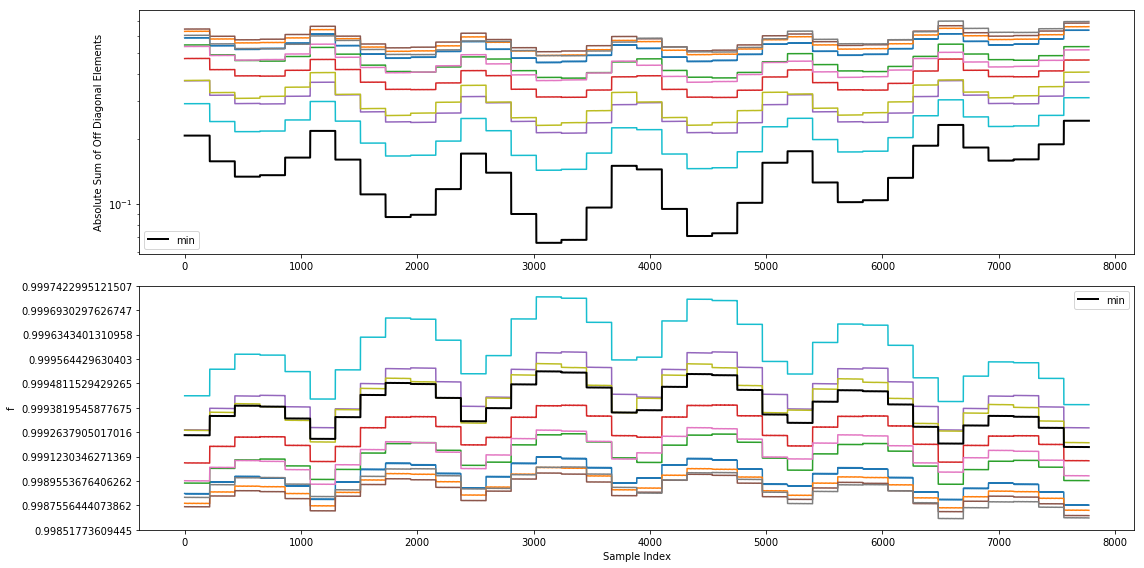

In [114]:
#pca1 = dill.load(open('../../../repos/randomized_controls/' + pcas[choice], 'rb'))
pca1 = dill.load(open(filename, 'rb'))
subweights = pca.weights_0[indices]
pca1.controlset = [pca1.controlset[i] for i in indices]
pca1.probs = list(np.array(subweights.T/sum(subweights)).T)
off_diagonals(pca1, scale)
